# chromatic_fitting

Add-on to the [chromatic](https://github.com/zkbt/chromatic) package to perform a simultaneous multi-wavelength transit fit

In [87]:
import chromatic
from chromatic import *
print("chromatic version = " + str(chromatic.version()))

chromatic version = 0.0.12


In [88]:
import pandas as pd
import numpy as np
import exoplanet as xo
import starry
from exotic_ld import limb_dark_fit
print("numpy version = " + str(np.__version__))
import theano
print("theano version = " + str(theano.__version__))
from astropy.constants import G
from astropy import units as u
import math
import pickle
import spectrum
from astropy.table import Table
# print(theano.config)

numpy version = 1.20.3
theano version = 1.1.2


## Import Patricio's multi-wavelength transit model:

In [3]:
x = pickle.load(open('data_challenge_spectra_v01.pickle', 'rb'))
x.keys()

dict_keys(['units', 'NGTS10b_parameters', 'WASP39b_parameters', 'NGTS10b_MIRI', 'WASP39b_NIRCam', 'WASP39b_NIRSpec', 'WASP39b_NIRISS'])

Load in planetary spectrum classes from ZBT defined [here](https://github.com/ers-transit/ers-data-checkpoint-showcase/blob/main/features/playing-around-with-patricio-signals_Catriona_edits.ipynb) 

In [6]:
# lets load a model
planet = x['WASP39b_NIRSpec']
planet_params = x['WASP39b_parameters']

wavelength = planet['wl']
depth = planet['transmission']
table = Table(dict(wavelength=planet['wl'], depth=planet['transmission']), meta=planet_params)

model = spectrum.PlanetarySpectrumModel(table=table, label='injected model')

units needed to be fudged for wavelength
units needed to be fudged for wavelength_lower
units needed to be fudged for wavelength_upper



🌈 Warning: 🌈 Assuming units for wavelength are micron.
🌈 Warning: 🌈 Assuming units for wavelength_lower are micron.
🌈 Warning: 🌈 Assuming units for wavelength_upper are micron.

In [14]:
planet_params

{'cosi': 0.03786459100977565,
 'a_rs': 11.37,
 'period': 4.055259,
 'rstar': 62265150000.0,
 'LDC_niriss1': [0.0, 0.7373, 0.0, -0.2928],
 'LDC_niriss2': [0.0, 0.8253, 0.0, -0.2624],
 'LDC_nirspec': [0.0, 0.2379, 0.0, 0.4615],
 'LDC_nircam': [0.0, 0.2379, 0.0, 0.4615]}

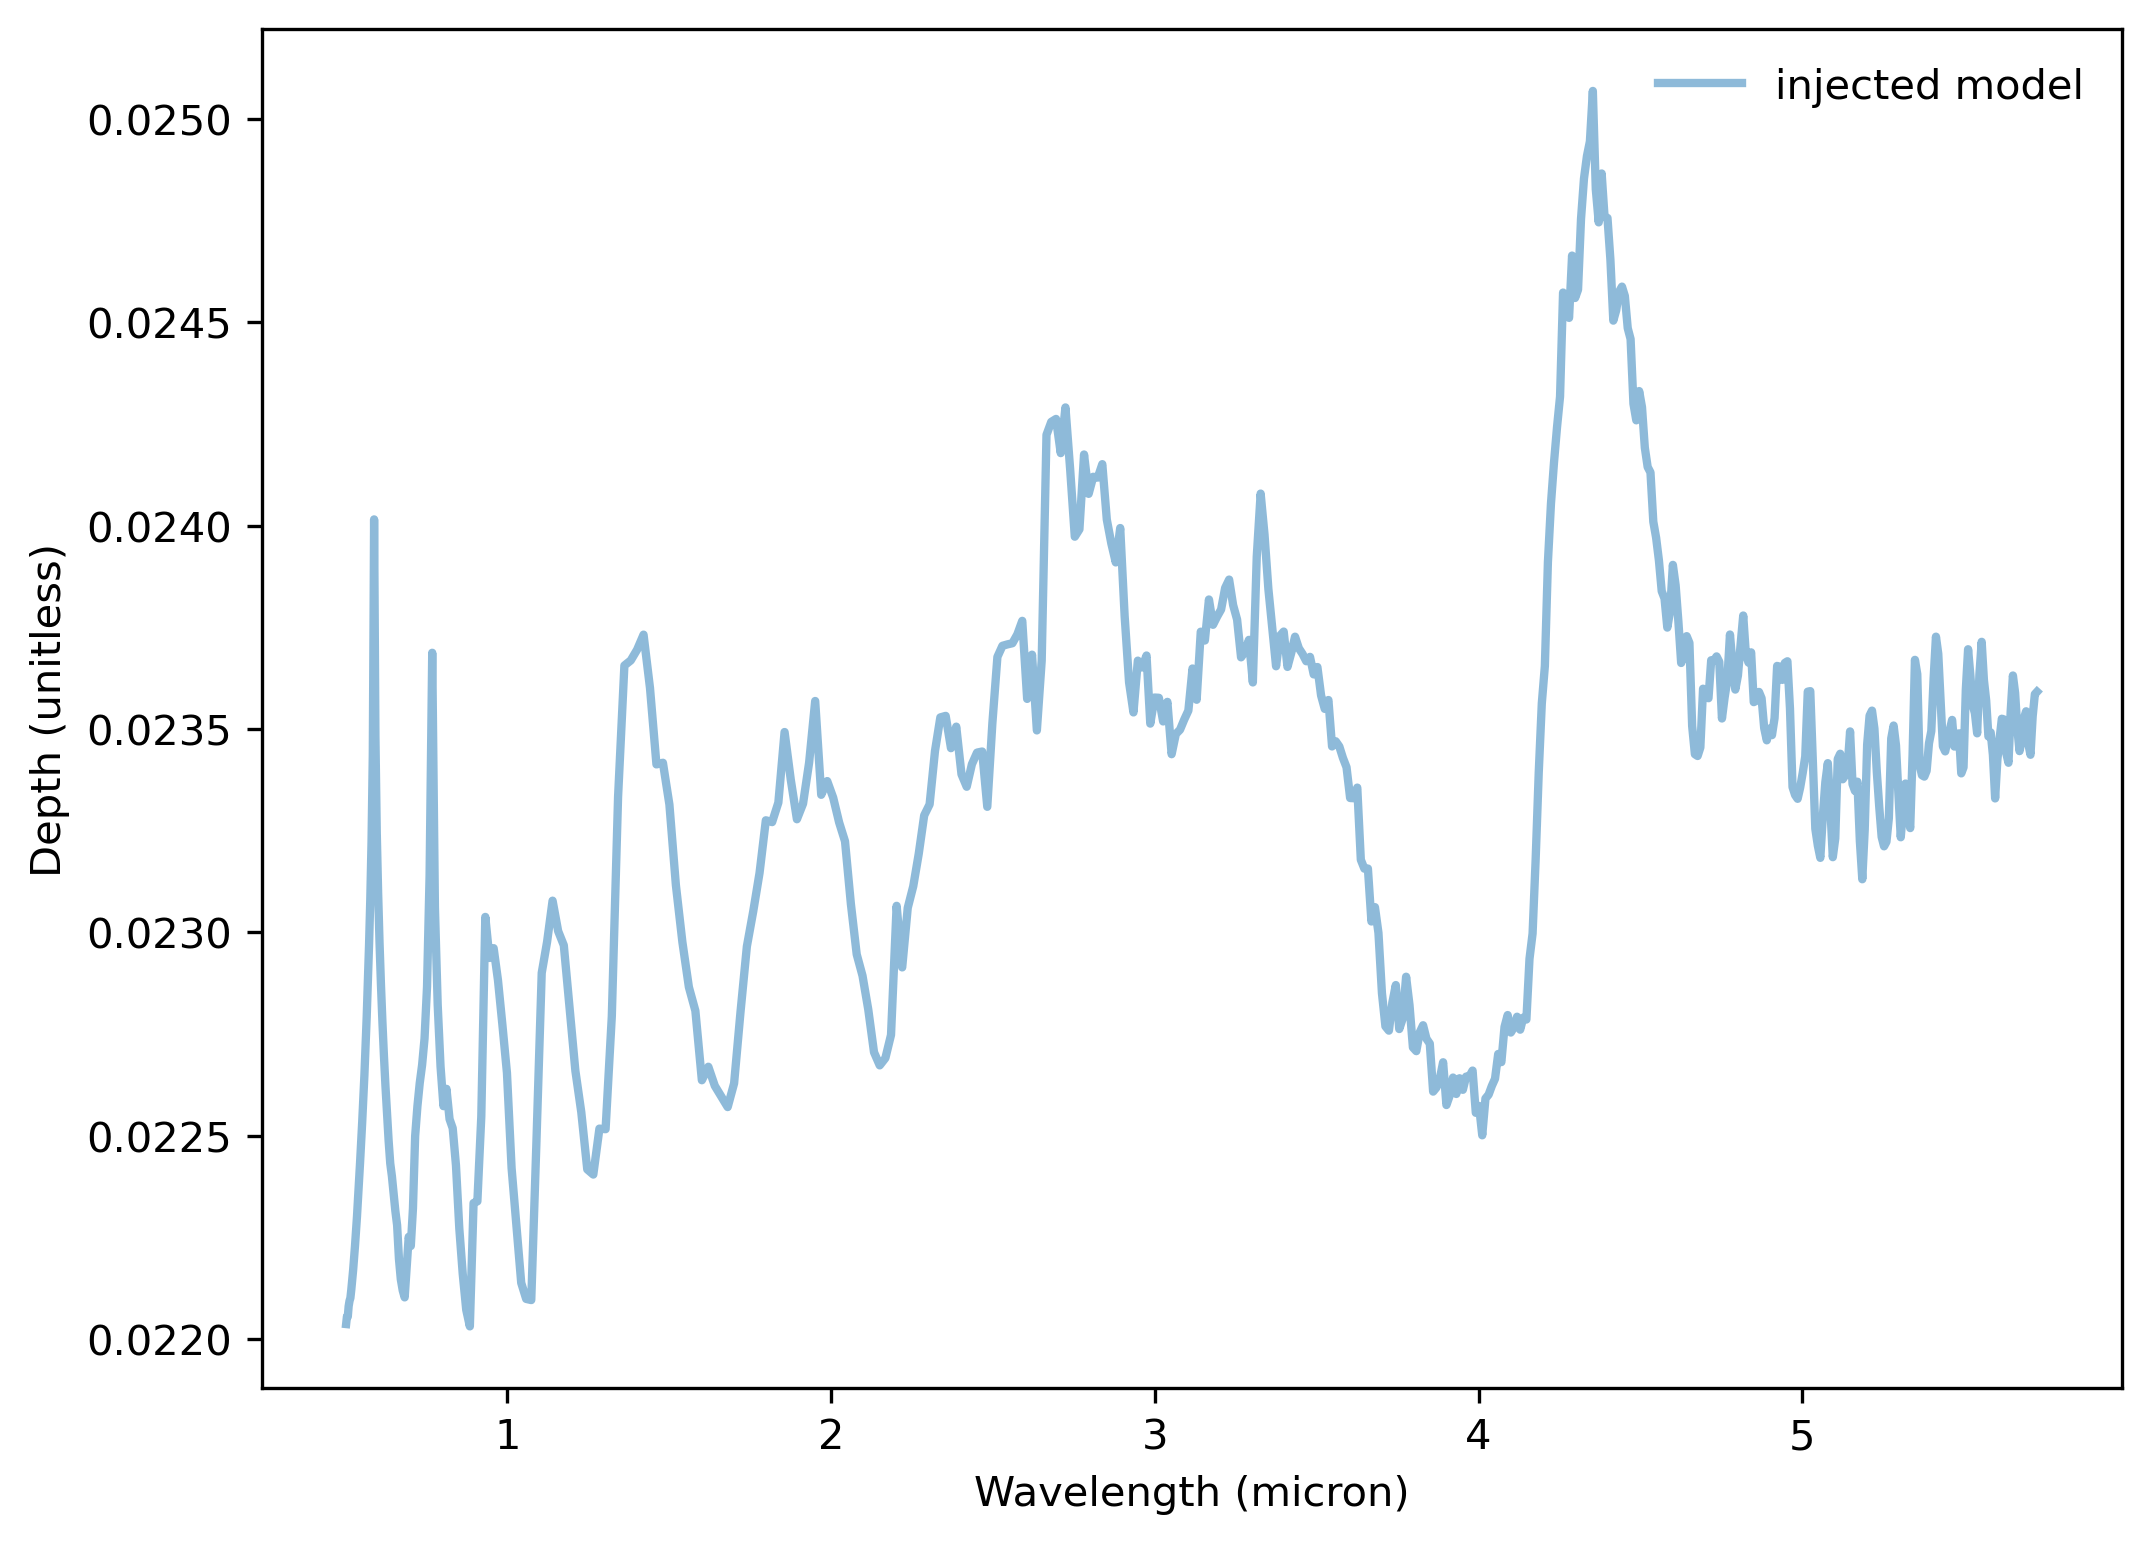

In [7]:
# plot model to check everything's okay
ax = model.plot( mode = 'WFC3_G141')
plt.legend(frameon=False);

In [ ]:
# JWST NIRCam mode
mode = 'NIRCam_F322W2'
# Set up the stellar parameters
M_H = 0.1
Teff = 5326.6
logg = 4.38933

# Tell it where the data from the Zenodo link has been placed
dirsen = '/Users/catrionamurray/Documents/Postdoc/CUBoulder/exotic-ld_data' 

# Tell it which stellar model grid you would like to use: '1D' or '3D'
ld_model = '1D' 

result = limb_dark_fit(mode, wavelength, M_H, Teff, logg, dirsen, ld_model=ld_model)

In [72]:
r = SimulatedRainbow(
    signal_to_noise=100, 
    dt=1*u.minute,
    wavelength=planet['wl']*u.micron,
    R=50)
i = r.inject_transit(
    planet_radius=np.sqrt(planet['transmission'])
)

In [73]:
# np.diff(planet['wl'])

In [74]:
b = i.bin(
    dw=0.1*u.micron, dt=10*u.minute
)


🌈 Warning: 
Uncertainties and/or data quality flags might
not be handled absolutely perfectly yet...

🌈 Warning: 
Uncertainties and/or data quality flags might
not be handled absolutely perfectly yet...


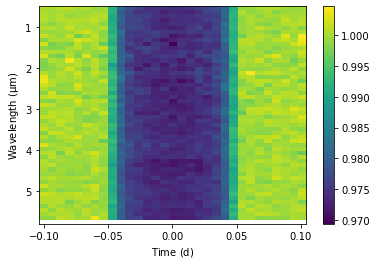

In [75]:
# i.imshow();
b.imshow();


🌈 Warning: 
Uncertainties and/or data quality flags might
not be handled absolutely perfectly yet...

🌈 Warning: 
Uncertainties and/or data quality flags might
not be handled absolutely perfectly yet...

🌈 Warning: 
Uncertainties and/or data quality flags might
not be handled absolutely perfectly yet...


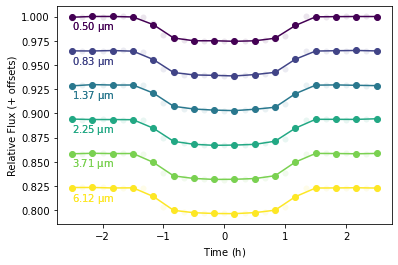

In [65]:
ax = b.bin(R=2).plot(plotkw=dict(alpha=0.1, markeredgecolor='none', linewidth=0))
b.bin(R=2, dt=20*u.minute).plot(ax=ax)

In [68]:
import altair as alt
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [76]:
def rainbow_to_vector(r):
    # r: rainbow object
    rflux = r.fluxlike['flux']         # flux (MJy/sr)        : [n_wavelengths x n_integrations]
    rfluxe = r.fluxlike['uncertainty'] # flux error (MJy/sr)  : [n_wavelengths x n_integrations]
    rtime = r.timelike['time']         # time (BJD_TDB, days) : [n_integrations]
    rwavel = r.wavelike['wavelength']  # wavelength (microns) : [n_wavelengths]
    return rflux,rfluxe,rtime,rwavel

In [77]:
flux, flux_error, time, wavelength = rainbow_to_vector(b)
# Compute x^2 + y^2 across a 2D grid
x, y = np.meshgrid(time, wavelength.to_value())

In [85]:
# Convert this grid to columnar data expected by Altair
def alt_imshow(x,y,z,xlabel,ylabel,zlabel,ylog=True):
    source = pd.DataFrame({'x': x.ravel(),
                         'y': y.ravel(),
                         'z': z.ravel()})
    
    brush = alt.selection(type='interval', encodings=['y'])

    if ylog==False:
        spectrum = alt.Chart(source,width=280,height=230).mark_rect(clip=True,width=200/len(x),height=300/len(y)).encode(
            x=alt.X('x:Q',scale=alt.Scale(zero=False),title=xlabel),
            y=alt.Y('y:Q',scale=alt.Scale(zero=False,domain=[round(np.min(y),2),round(np.max(y),2)]),title=ylabel),
            color=alt.Color('z:Q',title=zlabel,scale=alt.Scale(zero=False,domain=[np.min(z),np.max(z)])),
            tooltip=['x','y','z']
        )
    else:
        spectrum = alt.Chart(source,width=280,height=230).mark_rect(clip=True,width=200/len(x),height=300/len(y)).encode(
            x=alt.X('x:Q',scale=alt.Scale(zero=False),title=xlabel),
            y=alt.Y('y:Q',scale=alt.Scale(zero=False,base=10,type='log'),title=ylabel),
            color=alt.Color('z:Q',title=zlabel,scale=alt.Scale(zero=False,domain=[np.min(z),np.max(z)])),
            tooltip=['x','y','z']
        )

    # gray background with selection
    background = spectrum.encode(
        color=alt.value('#ddd')
    ).add_selection(brush)
    
    # highlights on the transformed data
    highlight = spectrum.transform_filter(brush)
    
    spectrum_int = alt.layer(
    background,
    highlight,
    data=source
    )
    
    lightcurve = alt.Chart(source,width=280,height=230,title="Mean Lightcurve for Wavelength Range").mark_point(filled=True,clip=True, size=20,color='black').encode(
    x=alt.X('x:Q',
            scale=alt.Scale(zero=False),title=xlabel),
    y=alt.Y('mean(z):Q',
            scale=alt.Scale(zero=False,domain=[0.98,1.01]),title='Mean '+zlabel)
    ).transform_filter(
    brush
    )
    
    return spectrum_int | lightcurve
    

In [86]:
alt_imshow(x,y,flux,xlabel='Time (h)',ylabel='log10(wavelength)',zlabel='Flux',ylog=False).display()

alt.HConcatChart(...)

In [84]:
flux

array([[1.00027125, 0.99988489, 1.0010757 , ..., 0.99925322, 0.9990814 ,
        0.99961749],
       [1.00019394, 0.99981159, 1.00021982, ..., 0.99960017, 0.99968371,
        0.99947034],
       [1.00055984, 0.99997661, 1.00065062, ..., 1.00040892, 0.99974038,
        1.00040945],
       ...,
       [0.9998035 , 1.0003812 , 1.00038916, ..., 0.99948458, 1.00023045,
        0.99997976],
       [0.99872729, 0.99880069, 1.00122559, ..., 0.99856001, 1.00030666,
        0.99973256],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])

In [57]:
def semi_major_axis(per,M,R):
    per_s = per * 24 * 60 * 60 * u.s
    R_sun = R * 696340000 * u.m
    M_sun = M * 1.989e30 * u.kg

    a = ((per_s)**2 * G * M_sun/ (4 * math.pi**2))**(1./3) # in units of m
    a_radii = a / R_sun

    return a_radii

In [58]:
def generate_planet_params(ldc=[0.65, 0.28], t0=0.0, p=1.0, R=1.0, M=1.0, i=0.5*math.pi, ecc=0, w=0):
    
    a = semi_major_axis(p,M,R)

    planet_params = {
                "t0": t0,
                "per": p,
                "a": a,
                "inc": i,
                "ecc": ecc,
                "w": w,
                "limb_dark": "nonlinear",
                "u": ldc,
            }
    
    return planet_params

In [28]:
ldc = planet_params['LDC_nircam']
radii_ratio = np.sqrt(planet['transmission'])
planet_params_inject = generate_planet_params(ldc)

In [29]:
i2 = r.inject_transit(planet_params = planet_params_inject,
    planet_radius=radii_ratio
)

Invalid planet radius array: must be float or have shape (116,)


# Testing out starry

In [73]:
star = starry.Primary(starry.Map(ydeg=0, udeg=2, amp=1.0), m=1.0, r=1.0, prot=1.0)
star.map[1] = 0.40
star.map[2] = 0.26

Compiling `render_ld`... Done.


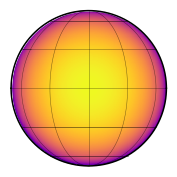

In [74]:
star.map.show()

In [75]:
planet = starry.kepler.Secondary(
    starry.Map(ydeg=5, amp=5e-3),  # the surface map
    m=0,  # mass in solar masses
    r=0.1,  # radius in solar radii
    porb=1.0,  # orbital period in days
    prot=1.0,  # rotation period in days (synchronous)
    Omega=30,  # longitude of ascending node in degrees
    ecc=0.3,  # eccentricity
    w=30,  # longitude of pericenter in degrees
    t0=0,  # time of transit in days
)

Pre-computing some matrices... Done.


In [76]:
np.random.seed(123)
planet.map[1:, :] = 0.01 * np.random.randn(planet.map.Ny - 1)

Compiling `render`... Done.


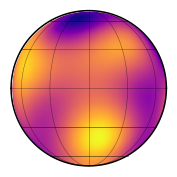

In [12]:
planet.map.show()

In [77]:
planet.theta0 = 180

In [19]:
# This routine performs gradient descent to try to find the global minimum of the map, and returns
# the latitude, longitude, and value of the intensity at the minimum.
planet.map.minimize()

ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn}(TensorConstant{25}, TensorConstant{[0.9952230...64586558]}, TensorConstant{[ 0.097627...76345115]}, TensorConstant{(25,) of 0.0}, TensorConstant{[-0.097627...76345115]}, TensorConstant{[0.9952230...64586558]}, TensorConstant{(25,) of 0.0}, TensorConstant{(25,) of 0.0}, TensorConstant{(25,) of 0.0}, TensorConstant{(25,) of 1.0}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/t


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_juyqzqby
library imit=] is not found.


ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn}(TensorConstant{25}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{(25,) of 0.0}, TensorConstant{[-0.770196...75544333]}, TensorConstant{(25,) of 0.0}, TensorConstant{[1. 1. 1. ..1. 1.
 1.]}, TensorConstant{(25,) of 0.0}, TensorConstant{[ 0.770196...75544333]}, TensorConstant{(25,) of 0.0}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_5hj3s427
library imit=] is not found.


ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn}(TensorConstant{25}, TensorConstant{[0.9952230...64586558]}, TensorConstant{[ 0.097627...76345115]}, TensorConstant{(25,) of 0.0}, TensorConstant{[-0.097627...76345115]}, TensorConstant{[0.9952230...64586558]}, TensorConstant{(25,) of 0.0}, TensorConstant{(25,) of 0.0}, TensorConstant{(25,) of 0.0}, TensorConstant{(25,) of 1.0}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/t


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_1gvmo5i9
library imit=] is not found.


ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn}(TensorConstant{25}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{(25,) of 0.0}, TensorConstant{[-0.770196...75544333]}, TensorConstant{(25,) of 0.0}, TensorConstant{[1. 1. 1. ..1. 1.
 1.]}, TensorConstant{(25,) of 0.0}, TensorConstant{[ 0.770196...75544333]}, TensorConstant{(25,) of 0.0}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_762uh7jx
library imit=] is not found.


ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn}(TensorConstant{25}, TensorConstant{[0.9952230...64586558]}, TensorConstant{[ 0.097627...76345115]}, TensorConstant{(25,) of 0.0}, TensorConstant{[-0.097627...76345115]}, TensorConstant{[0.9952230...64586558]}, TensorConstant{(25,) of 0.0}, TensorConstant{(25,) of 0.0}, TensorConstant{(25,) of 0.0}, TensorConstant{(25,) of 1.0}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/t


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_q7_4p7km
library imit=] is not found.


ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn}(TensorConstant{25}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{(25,) of 0.0}, TensorConstant{[-0.770196...75544333]}, TensorConstant{(25,) of 0.0}, TensorConstant{[1. 1. 1. ..1. 1.
 1.]}, TensorConstant{(25,) of 0.0}, TensorConstant{[ 0.770196...75544333]}, TensorConstant{(25,) of 0.0}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_zc67uxlb
library imit=] is not found.


ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn}(TensorConstant{25}, TensorConstant{[0.9952230...64586558]}, TensorConstant{[ 0.097627...76345115]}, TensorConstant{(25,) of 0.0}, TensorConstant{[-0.097627...76345115]}, TensorConstant{[0.9952230...64586558]}, TensorConstant{(25,) of 0.0}, TensorConstant{(25,) of 0.0}, TensorConstant{(25,) of 0.0}, TensorConstant{(25,) of 1.0}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/t


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_wml06b0t
library imit=] is not found.


ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn}(TensorConstant{25}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{(25,) of 0.0}, TensorConstant{[-0.770196...75544333]}, TensorConstant{(25,) of 0.0}, TensorConstant{[1. 1. 1. ..1. 1.
 1.]}, TensorConstant{(25,) of 0.0}, TensorConstant{[ 0.770196...75544333]}, TensorConstant{(25,) of 0.0}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_5fz_jesf
library imit=] is not found.


ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn&scan_fn}(TensorConstant{25}, TensorConstant{[0.9952230...64586558]}, TensorConstant{[ 0.097627...76345115]}, TensorConstant{[-0.097627...76345115]}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{[-0.770196...75544333]}, TensorConstant{[1. 1. 1. ..1. 1.
 1.]}, TensorConstant{[ 0.770196...75544333]}, TensorConstant{25}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/the


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_75u51e8s
library imit=] is not found.


ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn&scan_fn}(TensorConstant{25}, TensorConstant{[0.9952230...64586558]}, TensorConstant{[ 0.097627...76345115]}, TensorConstant{[-0.097627...76345115]}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{[-0.770196...75544333]}, TensorConstant{[1. 1. 1. ..1. 1.
 1.]}, TensorConstant{[ 0.770196...75544333]}, TensorConstant{25}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/the


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_dm8qq3gc
library imit=] is not found.


ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn&scan_fn}(TensorConstant{25}, TensorConstant{[0.9952230...64586558]}, TensorConstant{[ 0.097627...76345115]}, TensorConstant{[-0.097627...76345115]}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{[-0.770196...75544333]}, TensorConstant{[1. 1. 1. ..1. 1.
 1.]}, TensorConstant{[ 0.770196...75544333]}, TensorConstant{25}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/the


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_qzgtmh_n
library imit=] is not found.


ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn&scan_fn}(TensorConstant{25}, TensorConstant{[0.9952230...64586558]}, TensorConstant{[ 0.097627...76345115]}, TensorConstant{[-0.097627...76345115]}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{[-0.770196...75544333]}, TensorConstant{[1. 1. 1. ..1. 1.
 1.]}, TensorConstant{[ 0.770196...75544333]}, TensorConstant{25}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/the


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_sqbwrt9x
library imit=] is not found.


ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: for{cpu,scan_fn&scan_fn}(TensorConstant{25}, TensorConstant{[0.9952230...64586558]}, TensorConstant{[ 0.097627...76345115]}, TensorConstant{[-0.097627...76345115]}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{[-0.770196...75544333]}, TensorConstant{[1. 1. 1. ..1. 1.
 1.]}, TensorConstant{[ 0.770196...75544333]}, TensorConstant{25}, TensorConstant{25})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/theano/scan/scan_perform_ext.py", line 47, in <module>
    raise ImportError("Scan code version mismatch")
ImportError: Scan code version mismatch

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/the


You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_mgwztuos
library imit=] is not found.

You can find the C code in this temporary file: /var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/theano_compilation_error_5v0o19fq
library imit=] is not found.


Exception: ('The following error happened while compiling the node', for{cpu,scan_fn&scan_fn}(TensorConstant{25}, TensorConstant{[0.9952230...64586558]}, TensorConstant{[ 0.097627...76345115]}, TensorConstant{[-0.097627...76345115]}, TensorConstant{[ 0.637806...65521399]}, TensorConstant{[-0.770196...75544333]}, TensorConstant{[1. 1. 1. ..1. 1.
 1.]}, TensorConstant{[ 0.770196...75544333]}, TensorConstant{25}, TensorConstant{25}), '\n', 'Compilation failed (return status=1): In file included from /Users/catrionamurray/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.9.7-64/scan_perform/mod.cpp:4:. In file included from /Users/catrionamurray/opt/anaconda3/envs/ers-transit/include/python3.9/Python.h:25:. In file included from /usr/local/include/stdio.h:64:. /usr/local/include/_stdio.h:93:16: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         unsigned char   *_base;.                         ^. /usr/local/include/_stdio.h:93:16: note: insert \'_Nullable\' if the pointer may be null.         unsigned char   *_base;.                         ^.                           _Nullable . /usr/local/include/_stdio.h:93:16: note: insert \'_Nonnull\' if the pointer should never be null.         unsigned char   *_base;.                         ^.                           _Nonnull . /usr/local/include/_stdio.h:138:32: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         int     (* _Nullable _read) (void *, char *, int);.                                           ^. /usr/local/include/_stdio.h:138:32: note: insert \'_Nullable\' if the pointer may be null.         int     (* _Nullable _read) (void *, char *, int);.                                           ^.                                            _Nullable. /usr/local/include/_stdio.h:138:32: note: insert \'_Nonnull\' if the pointer should never be null.         int     (* _Nullable _read) (void *, char *, int);.                                           ^.                                            _Nonnull. /usr/local/include/_stdio.h:138:40: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         int     (* _Nullable _read) (void *, char *, int);.                                                   ^. /usr/local/include/_stdio.h:138:40: note: insert \'_Nullable\' if the pointer may be null.         int     (* _Nullable _read) (void *, char *, int);.                                                   ^.                                                    _Nullable. /usr/local/include/_stdio.h:138:40: note: insert \'_Nonnull\' if the pointer should never be null.         int     (* _Nullable _read) (void *, char *, int);.                                                   ^.                                                    _Nonnull. /usr/local/include/_stdio.h:139:35: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         fpos_t  (* _Nullable _seek) (void *, fpos_t, int);.                                           ^. /usr/local/include/_stdio.h:139:35: note: insert \'_Nullable\' if the pointer may be null.         fpos_t  (* _Nullable _seek) (void *, fpos_t, int);.                                           ^.                                            _Nullable. /usr/local/include/_stdio.h:139:35: note: insert \'_Nonnull\' if the pointer should never be null.         fpos_t  (* _Nullable _seek) (void *, fpos_t, int);.                                           ^.                                            _Nonnull. /usr/local/include/_stdio.h:140:32: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         int     (* _Nullable _write)(void *, const char *, int);.                                           ^. /usr/local/include/_stdio.h:140:32: note: insert \'_Nullable\' if the pointer may be null.         int     (* _Nullable _write)(void *, const char *, int);.                                           ^.                                            _Nullable. /usr/local/include/_stdio.h:140:32: note: insert \'_Nonnull\' if the pointer should never be null.         int     (* _Nullable _write)(void *, const char *, int);.                                           ^.                                            _Nonnull. /usr/local/include/_stdio.h:140:46: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         int     (* _Nullable _write)(void *, const char *, int);.                                                         ^. /usr/local/include/_stdio.h:140:46: note: insert \'_Nullable\' if the pointer may be null.         int     (* _Nullable _write)(void *, const char *, int);.                                                         ^.                                                          _Nullable. /usr/local/include/_stdio.h:140:46: note: insert \'_Nonnull\' if the pointer should never be null.         int     (* _Nullable _write)(void *, const char *, int);.                                                         ^.                                                          _Nonnull. /usr/local/include/_stdio.h:144:18: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         struct __sFILEX *_extra; /* additions to FILE to not break ABI */.                         ^. /usr/local/include/_stdio.h:144:18: note: insert \'_Nullable\' if the pointer may be null.         struct __sFILEX *_extra; /* additions to FILE to not break ABI */.                         ^.                           _Nullable . /usr/local/include/_stdio.h:144:18: note: insert \'_Nonnull\' if the pointer should never be null.         struct __sFILEX *_extra; /* additions to FILE to not break ABI */.                         ^.                           _Nonnull . In file included from /Users/catrionamurray/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.9.7-64/scan_perform/mod.cpp:4:. In file included from /Users/catrionamurray/opt/anaconda3/envs/ers-transit/include/python3.9/Python.h:25:. /usr/local/include/stdio.h:67:13: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. extern FILE *__stdinp;.             ^. /usr/local/include/stdio.h:67:13: note: insert \'_Nullable\' if the pointer may be null. extern FILE *__stdinp;.             ^.               _Nullable . /usr/local/include/stdio.h:67:13: note: insert \'_Nonnull\' if the pointer should never be null. extern FILE *__stdinp;.             ^.               _Nonnull . /usr/local/include/stdio.h:386:41: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].                  int (* _Nullable)(void *, const char *, int),.                                         ^. /usr/local/include/stdio.h:386:41: note: insert \'_Nullable\' if the pointer may be null.                  int (* _Nullable)(void *, const char *, int),.                                         ^.                                          _Nullable. /usr/local/include/stdio.h:386:41: note: insert \'_Nonnull\' if the pointer should never be null.                  int (* _Nullable)(void *, const char *, int),.                                         ^.                                          _Nonnull. /usr/local/include/stdio.h:386:55: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].                  int (* _Nullable)(void *, const char *, int),.                                                       ^. /usr/local/include/stdio.h:386:55: note: insert \'_Nullable\' if the pointer may be null.                  int (* _Nullable)(void *, const char *, int),.                                                       ^.                                                        _Nullable. /usr/local/include/stdio.h:386:55: note: insert \'_Nonnull\' if the pointer should never be null.                  int (* _Nullable)(void *, const char *, int),.                                                       ^.                                                        _Nonnull. /usr/local/include/stdio.h:387:44: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].                  fpos_t (* _Nullable)(void *, fpos_t, int),.                                            ^. /usr/local/include/stdio.h:387:44: note: insert \'_Nullable\' if the pointer may be null.                  fpos_t (* _Nullable)(void *, fpos_t, int),.                                            ^.                                             _Nullable. /usr/local/include/stdio.h:387:44: note: insert \'_Nonnull\' if the pointer should never be null.                  fpos_t (* _Nullable)(void *, fpos_t, int),.                                            ^.                                             _Nonnull. /usr/local/include/stdio.h:388:41: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].                  int (* _Nullable)(void *));.                                         ^. /usr/local/include/stdio.h:388:41: note: insert \'_Nullable\' if the pointer may be null.                  int (* _Nullable)(void *));.                                         ^.                                          _Nullable. /usr/local/include/stdio.h:388:41: note: insert \'_Nonnull\' if the pointer should never be null.                  int (* _Nullable)(void *));.                                         ^.                                          _Nonnull. /usr/local/include/stdio.h:384:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. FILE    *funopen(const void *,.         ^. /usr/local/include/stdio.h:384:6: note: insert \'_Nullable\' if the pointer may be null. FILE    *funopen(const void *,.         ^.           _Nullable . /usr/local/include/stdio.h:384:6: note: insert \'_Nonnull\' if the pointer should never be null. FILE    *funopen(const void *,.         ^.           _Nonnull . In file included from /Users/catrionamurray/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.9.7-64/scan_perform/mod.cpp:4:. In file included from /Users/catrionamurray/opt/anaconda3/envs/ers-transit/include/python3.9/Python.h:34:. /usr/local/include/stdlib.h:134:25: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. double   atof(const char *);.                          ^. /usr/local/include/stdlib.h:134:25: note: insert \'_Nullable\' if the pointer may be null. double   atof(const char *);.                          ^.                           _Nullable. /usr/local/include/stdlib.h:134:25: note: insert \'_Nonnull\' if the pointer should never be null. double   atof(const char *);.                          ^.                           _Nonnull. /usr/local/include/stdlib.h:135:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      atoi(const char *);.                          ^. /usr/local/include/stdlib.h:135:22: note: insert \'_Nullable\' if the pointer may be null. int      atoi(const char *);.                          ^.                           _Nullable. /usr/local/include/stdlib.h:135:22: note: insert \'_Nonnull\' if the pointer should never be null. int      atoi(const char *);.                          ^.                           _Nonnull. /usr/local/include/stdlib.h:136:23: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. long     atol(const char *);.                          ^. /usr/local/include/stdlib.h:136:23: note: insert \'_Nullable\' if the pointer may be null. long     atol(const char *);.                          ^.                           _Nullable. /usr/local/include/stdlib.h:136:23: note: insert \'_Nonnull\' if the pointer should never be null. long     atol(const char *);.                          ^.                           _Nonnull. /usr/local/include/stdlib.h:139:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          atoll(const char *);.                           ^. /usr/local/include/stdlib.h:139:20: note: insert \'_Nullable\' if the pointer may be null.          atoll(const char *);.                           ^.                            _Nullable. /usr/local/include/stdlib.h:139:20: note: insert \'_Nonnull\' if the pointer should never be null.          atoll(const char *);.                           ^.                            _Nonnull. /usr/local/include/stdlib.h:141:26: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void    *bsearch(const void *__key, const void *__base, size_t __nel,.                             ^. /usr/local/include/stdlib.h:141:26: note: insert \'_Nullable\' if the pointer may be null. void    *bsearch(const void *__key, const void *__base, size_t __nel,.                             ^.                               _Nullable . /usr/local/include/stdlib.h:141:26: note: insert \'_Nonnull\' if the pointer should never be null. void    *bsearch(const void *__key, const void *__base, size_t __nel,.                             ^.                               _Nonnull . /usr/local/include/stdlib.h:141:45: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void    *bsearch(const void *__key, const void *__base, size_t __nel,.                                                ^. /usr/local/include/stdlib.h:141:45: note: insert \'_Nullable\' if the pointer may be null. void    *bsearch(const void *__key, const void *__base, size_t __nel,.                                                ^.                                                  _Nullable . /usr/local/include/stdlib.h:141:45: note: insert \'_Nonnull\' if the pointer should never be null. void    *bsearch(const void *__key, const void *__base, size_t __nel,.                                                ^.                                                  _Nonnull . /usr/local/include/stdlib.h:142:59: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             size_t __width, int (* _Nonnull __compar)(const void *, const void *));.                                                                  ^. /usr/local/include/stdlib.h:142:59: note: insert \'_Nullable\' if the pointer may be null.             size_t __width, int (* _Nonnull __compar)(const void *, const void *));.                                                                  ^.                                                                   _Nullable. /usr/local/include/stdlib.h:142:59: note: insert \'_Nonnull\' if the pointer should never be null.             size_t __width, int (* _Nonnull __compar)(const void *, const void *));.                                                                  ^.                                                                   _Nonnull. /usr/local/include/stdlib.h:142:73: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             size_t __width, int (* _Nonnull __compar)(const void *, const void *));.                                                                                ^. /usr/local/include/stdlib.h:142:73: note: insert \'_Nullable\' if the pointer may be null.             size_t __width, int (* _Nonnull __compar)(const void *, const void *));.                                                                                ^.                                                                                 _Nullable. /usr/local/include/stdlib.h:142:73: note: insert \'_Nonnull\' if the pointer should never be null.             size_t __width, int (* _Nonnull __compar)(const void *, const void *));.                                                                                ^.                                                                                 _Nonnull. /usr/local/include/stdlib.h:141:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void    *bsearch(const void *__key, const void *__base, size_t __nel,.         ^. /usr/local/include/stdlib.h:141:6: note: insert \'_Nullable\' if the pointer may be null. void    *bsearch(const void *__key, const void *__base, size_t __nel,.         ^.           _Nullable . /usr/local/include/stdlib.h:141:6: note: insert \'_Nonnull\' if the pointer should never be null. void    *bsearch(const void *__key, const void *__base, size_t __nel,.         ^.           _Nonnull . /usr/local/include/stdlib.h:147:25: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *getenv(const char *);.                            ^. /usr/local/include/stdlib.h:147:25: note: insert \'_Nullable\' if the pointer may be null. char    *getenv(const char *);.                            ^.                             _Nullable. /usr/local/include/stdlib.h:147:25: note: insert \'_Nonnull\' if the pointer should never be null. char    *getenv(const char *);.                            ^.                             _Nonnull. /usr/local/include/stdlib.h:147:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *getenv(const char *);.         ^. /usr/local/include/stdlib.h:147:6: note: insert \'_Nullable\' if the pointer may be null. char    *getenv(const char *);.         ^.           _Nullable . /usr/local/include/stdlib.h:147:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *getenv(const char *);.         ^.           _Nonnull . /usr/local/include/stdlib.h:156:23: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      mblen(const char *__s, size_t __n);.                           ^. /usr/local/include/stdlib.h:156:23: note: insert \'_Nullable\' if the pointer may be null. int      mblen(const char *__s, size_t __n);.                           ^.                             _Nullable . /usr/local/include/stdlib.h:156:23: note: insert \'_Nonnull\' if the pointer should never be null. int      mblen(const char *__s, size_t __n);.                           ^.                             _Nonnull . /usr/local/include/stdlib.h:157:26: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. size_t   mbstowcs(wchar_t * __restrict , const char * __restrict, size_t);.                           ^. /usr/local/include/stdlib.h:157:26: note: insert \'_Nullable\' if the pointer may be null. size_t   mbstowcs(wchar_t * __restrict , const char * __restrict, size_t);.                           ^.                             _Nullable. /usr/local/include/stdlib.h:157:26: note: insert \'_Nonnull\' if the pointer should never be null. size_t   mbstowcs(wchar_t * __restrict , const char * __restrict, size_t);.                           ^.                             _Nonnull. /usr/local/include/stdlib.h:157:52: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. size_t   mbstowcs(wchar_t * __restrict , const char * __restrict, size_t);.                                                     ^. /usr/local/include/stdlib.h:157:52: note: insert \'_Nullable\' if the pointer may be null. size_t   mbstowcs(wchar_t * __restrict , const char * __restrict, size_t);.                                                     ^.                                                       _Nullable. /usr/local/include/stdlib.h:157:52: note: insert \'_Nonnull\' if the pointer should never be null. size_t   mbstowcs(wchar_t * __restrict , const char * __restrict, size_t);.                                                     ^.                                                       _Nonnull. /usr/local/include/stdlib.h:158:21: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      mbtowc(wchar_t * __restrict, const char * __restrict, size_t);.                         ^. /usr/local/include/stdlib.h:158:21: note: insert \'_Nullable\' if the pointer may be null. int      mbtowc(wchar_t * __restrict, const char * __restrict, size_t);.                         ^.                           _Nullable. /usr/local/include/stdlib.h:158:21: note: insert \'_Nonnull\' if the pointer should never be null. int      mbtowc(wchar_t * __restrict, const char * __restrict, size_t);.                         ^.                           _Nonnull. /usr/local/include/stdlib.h:158:46: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      mbtowc(wchar_t * __restrict, const char * __restrict, size_t);.                                                  ^. /usr/local/include/stdlib.h:158:46: note: insert \'_Nullable\' if the pointer may be null. int      mbtowc(wchar_t * __restrict, const char * __restrict, size_t);.                                                  ^.                                                    _Nullable. /usr/local/include/stdlib.h:158:46: note: insert \'_Nonnull\' if the pointer should never be null. int      mbtowc(wchar_t * __restrict, const char * __restrict, size_t);.                                                  ^.                                                    _Nonnull. /usr/local/include/stdlib.h:160:18: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     qsort(void *__base, size_t __nel, size_t __width,.                     ^. /usr/local/include/stdlib.h:160:18: note: insert \'_Nullable\' if the pointer may be null. void     qsort(void *__base, size_t __nel, size_t __width,.                     ^.                       _Nullable . /usr/local/include/stdlib.h:160:18: note: insert \'_Nonnull\' if the pointer should never be null. void     qsort(void *__base, size_t __nel, size_t __width,.                     ^.                       _Nonnull . /usr/local/include/stdlib.h:161:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(const void *, const void *));.                                                  ^. /usr/local/include/stdlib.h:161:43: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                  ^.                                                   _Nullable. /usr/local/include/stdlib.h:161:43: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                  ^.                                                   _Nonnull. /usr/local/include/stdlib.h:161:57: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(const void *, const void *));.                                                                ^. /usr/local/include/stdlib.h:161:57: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                                ^.                                                                 _Nullable. /usr/local/include/stdlib.h:161:57: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                                ^.                                                                 _Nonnull. /usr/local/include/stdlib.h:165:27: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. double   strtod(const char *, char **) __DARWIN_ALIAS(strtod);.                            ^. /usr/local/include/stdlib.h:165:27: note: insert \'_Nullable\' if the pointer may be null. double   strtod(const char *, char **) __DARWIN_ALIAS(strtod);.                            ^.                             _Nullable. /usr/local/include/stdlib.h:165:27: note: insert \'_Nonnull\' if the pointer should never be null. double   strtod(const char *, char **) __DARWIN_ALIAS(strtod);.                            ^.                             _Nonnull. /usr/local/include/stdlib.h:165:35: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. double   strtod(const char *, char **) __DARWIN_ALIAS(strtod);.                                    ^. /usr/local/include/stdlib.h:165:35: note: insert \'_Nullable\' if the pointer may be null. double   strtod(const char *, char **) __DARWIN_ALIAS(strtod);.                                    ^.                                     _Nullable. /usr/local/include/stdlib.h:165:35: note: insert \'_Nonnull\' if the pointer should never be null. double   strtod(const char *, char **) __DARWIN_ALIAS(strtod);.                                    ^.                                     _Nonnull. /usr/local/include/stdlib.h:165:36: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. double   strtod(const char *, char **) __DARWIN_ALIAS(strtod);.                                     ^. /usr/local/include/stdlib.h:165:36: note: insert \'_Nullable\' if the pointer may be null. double   strtod(const char *, char **) __DARWIN_ALIAS(strtod);.                                     ^.                                      _Nullable. /usr/local/include/stdlib.h:165:36: note: insert \'_Nonnull\' if the pointer should never be null. double   strtod(const char *, char **) __DARWIN_ALIAS(strtod);.                                     ^.                                      _Nonnull. /usr/local/include/stdlib.h:166:26: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. float    strtof(const char *, char **) __DARWIN_ALIAS(strtof);.                            ^. /usr/local/include/stdlib.h:166:26: note: insert \'_Nullable\' if the pointer may be null. float    strtof(const char *, char **) __DARWIN_ALIAS(strtof);.                            ^.                             _Nullable. /usr/local/include/stdlib.h:166:26: note: insert \'_Nonnull\' if the pointer should never be null. float    strtof(const char *, char **) __DARWIN_ALIAS(strtof);.                            ^.                             _Nonnull. /usr/local/include/stdlib.h:166:34: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. float    strtof(const char *, char **) __DARWIN_ALIAS(strtof);.                                    ^. /usr/local/include/stdlib.h:166:34: note: insert \'_Nullable\' if the pointer may be null. float    strtof(const char *, char **) __DARWIN_ALIAS(strtof);.                                    ^.                                     _Nullable. /usr/local/include/stdlib.h:166:34: note: insert \'_Nonnull\' if the pointer should never be null. float    strtof(const char *, char **) __DARWIN_ALIAS(strtof);.                                    ^.                                     _Nonnull. /usr/local/include/stdlib.h:166:35: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. float    strtof(const char *, char **) __DARWIN_ALIAS(strtof);.                                     ^. /usr/local/include/stdlib.h:166:35: note: insert \'_Nullable\' if the pointer may be null. float    strtof(const char *, char **) __DARWIN_ALIAS(strtof);.                                     ^.                                      _Nullable. /usr/local/include/stdlib.h:166:35: note: insert \'_Nonnull\' if the pointer should never be null. float    strtof(const char *, char **) __DARWIN_ALIAS(strtof);.                                     ^.                                      _Nonnull. /usr/local/include/stdlib.h:167:25: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. long     strtol(const char *__str, char **__endptr, int __base);.                            ^. /usr/local/include/stdlib.h:167:25: note: insert \'_Nullable\' if the pointer may be null. long     strtol(const char *__str, char **__endptr, int __base);.                            ^.                              _Nullable . /usr/local/include/stdlib.h:167:25: note: insert \'_Nonnull\' if the pointer should never be null. long     strtol(const char *__str, char **__endptr, int __base);.                            ^.                              _Nonnull . /usr/local/include/stdlib.h:167:38: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. long     strtol(const char *__str, char **__endptr, int __base);.                                         ^. /usr/local/include/stdlib.h:167:38: note: insert \'_Nullable\' if the pointer may be null. long     strtol(const char *__str, char **__endptr, int __base);.                                         ^.                                          _Nullable. /usr/local/include/stdlib.h:167:38: note: insert \'_Nonnull\' if the pointer should never be null. long     strtol(const char *__str, char **__endptr, int __base);.                                         ^.                                          _Nonnull. /usr/local/include/stdlib.h:167:39: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. long     strtol(const char *__str, char **__endptr, int __base);.                                          ^. /usr/local/include/stdlib.h:167:39: note: insert \'_Nullable\' if the pointer may be null. long     strtol(const char *__str, char **__endptr, int __base);.                                          ^.                                            _Nullable . /usr/local/include/stdlib.h:167:39: note: insert \'_Nonnull\' if the pointer should never be null. long     strtol(const char *__str, char **__endptr, int __base);.                                          ^.                                            _Nonnull . /usr/local/include/stdlib.h:169:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtold(const char *, char **);.                             ^. /usr/local/include/stdlib.h:169:22: note: insert \'_Nullable\' if the pointer may be null.          strtold(const char *, char **);.                             ^.                              _Nullable. /usr/local/include/stdlib.h:169:22: note: insert \'_Nonnull\' if the pointer should never be null.          strtold(const char *, char **);.                             ^.                              _Nonnull. /usr/local/include/stdlib.h:169:30: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtold(const char *, char **);.                                     ^. /usr/local/include/stdlib.h:169:30: note: insert \'_Nullable\' if the pointer may be null.          strtold(const char *, char **);.                                     ^.                                      _Nullable. /usr/local/include/stdlib.h:169:30: note: insert \'_Nonnull\' if the pointer should never be null.          strtold(const char *, char **);.                                     ^.                                      _Nonnull. /usr/local/include/stdlib.h:169:31: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtold(const char *, char **);.                                      ^. /usr/local/include/stdlib.h:169:31: note: insert \'_Nullable\' if the pointer may be null.          strtold(const char *, char **);.                                      ^.                                       _Nullable. /usr/local/include/stdlib.h:169:31: note: insert \'_Nonnull\' if the pointer should never be null.          strtold(const char *, char **);.                                      ^.                                       _Nonnull. /usr/local/include/stdlib.h:172:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoll(const char *__str, char **__endptr, int __base);.                             ^. /usr/local/include/stdlib.h:172:22: note: insert \'_Nullable\' if the pointer may be null.          strtoll(const char *__str, char **__endptr, int __base);.                             ^.                               _Nullable . /usr/local/include/stdlib.h:172:22: note: insert \'_Nonnull\' if the pointer should never be null.          strtoll(const char *__str, char **__endptr, int __base);.                             ^.                               _Nonnull . /usr/local/include/stdlib.h:172:35: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoll(const char *__str, char **__endptr, int __base);.                                          ^. /usr/local/include/stdlib.h:172:35: note: insert \'_Nullable\' if the pointer may be null.          strtoll(const char *__str, char **__endptr, int __base);.                                          ^.                                           _Nullable. /usr/local/include/stdlib.h:172:35: note: insert \'_Nonnull\' if the pointer should never be null.          strtoll(const char *__str, char **__endptr, int __base);.                                          ^.                                           _Nonnull. /usr/local/include/stdlib.h:172:36: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoll(const char *__str, char **__endptr, int __base);.                                           ^. /usr/local/include/stdlib.h:172:36: note: insert \'_Nullable\' if the pointer may be null.          strtoll(const char *__str, char **__endptr, int __base);.                                           ^.                                             _Nullable . /usr/local/include/stdlib.h:172:36: note: insert \'_Nonnull\' if the pointer should never be null.          strtoll(const char *__str, char **__endptr, int __base);.                                           ^.                                             _Nonnull . /usr/local/include/stdlib.h:175:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoul(const char *__str, char **__endptr, int __base);.                             ^. /usr/local/include/stdlib.h:175:22: note: insert \'_Nullable\' if the pointer may be null.          strtoul(const char *__str, char **__endptr, int __base);.                             ^.                               _Nullable . /usr/local/include/stdlib.h:175:22: note: insert \'_Nonnull\' if the pointer should never be null.          strtoul(const char *__str, char **__endptr, int __base);.                             ^.                               _Nonnull . /usr/local/include/stdlib.h:175:35: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoul(const char *__str, char **__endptr, int __base);.                                          ^. /usr/local/include/stdlib.h:175:35: note: insert \'_Nullable\' if the pointer may be null.          strtoul(const char *__str, char **__endptr, int __base);.                                          ^.                                           _Nullable. /usr/local/include/stdlib.h:175:35: note: insert \'_Nonnull\' if the pointer should never be null.          strtoul(const char *__str, char **__endptr, int __base);.                                          ^.                                           _Nonnull. /usr/local/include/stdlib.h:175:36: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoul(const char *__str, char **__endptr, int __base);.                                           ^. /usr/local/include/stdlib.h:175:36: note: insert \'_Nullable\' if the pointer may be null.          strtoul(const char *__str, char **__endptr, int __base);.                                           ^.                                             _Nullable . /usr/local/include/stdlib.h:175:36: note: insert \'_Nonnull\' if the pointer should never be null.          strtoul(const char *__str, char **__endptr, int __base);.                                           ^.                                             _Nonnull . /usr/local/include/stdlib.h:178:23: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoull(const char *__str, char **__endptr, int __base);.                              ^. /usr/local/include/stdlib.h:178:23: note: insert \'_Nullable\' if the pointer may be null.          strtoull(const char *__str, char **__endptr, int __base);.                              ^.                                _Nullable . /usr/local/include/stdlib.h:178:23: note: insert \'_Nonnull\' if the pointer should never be null.          strtoull(const char *__str, char **__endptr, int __base);.                              ^.                                _Nonnull . /usr/local/include/stdlib.h:178:36: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoull(const char *__str, char **__endptr, int __base);.                                           ^. /usr/local/include/stdlib.h:178:36: note: insert \'_Nullable\' if the pointer may be null.          strtoull(const char *__str, char **__endptr, int __base);.                                           ^.                                            _Nullable. /usr/local/include/stdlib.h:178:36: note: insert \'_Nonnull\' if the pointer should never be null.          strtoull(const char *__str, char **__endptr, int __base);.                                           ^.                                            _Nonnull. /usr/local/include/stdlib.h:178:37: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoull(const char *__str, char **__endptr, int __base);.                                            ^. /usr/local/include/stdlib.h:178:37: note: insert \'_Nullable\' if the pointer may be null.          strtoull(const char *__str, char **__endptr, int __base);.                                            ^.                                              _Nullable . /usr/local/include/stdlib.h:178:37: note: insert \'_Nonnull\' if the pointer should never be null.          strtoull(const char *__str, char **__endptr, int __base);.                                            ^.                                              _Nonnull . /usr/local/include/stdlib.h:190:24: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      system(const char *) __DARWIN_ALIAS_C(system);.                            ^. /usr/local/include/stdlib.h:190:24: note: insert \'_Nullable\' if the pointer may be null. int      system(const char *) __DARWIN_ALIAS_C(system);.                            ^.                             _Nullable. /usr/local/include/stdlib.h:190:24: note: insert \'_Nonnull\' if the pointer should never be null. int      system(const char *) __DARWIN_ALIAS_C(system);.                            ^.                             _Nonnull. /usr/local/include/stdlib.h:194:23: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. size_t   wcstombs(char * __restrict, const wchar_t * __restrict, size_t);.                        ^. /usr/local/include/stdlib.h:194:23: note: insert \'_Nullable\' if the pointer may be null. size_t   wcstombs(char * __restrict, const wchar_t * __restrict, size_t);.                        ^.                          _Nullable. /usr/local/include/stdlib.h:194:23: note: insert \'_Nonnull\' if the pointer should never be null. size_t   wcstombs(char * __restrict, const wchar_t * __restrict, size_t);.                        ^.                          _Nonnull. /usr/local/include/stdlib.h:194:51: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. size_t   wcstombs(char * __restrict, const wchar_t * __restrict, size_t);.                                                    ^. /usr/local/include/stdlib.h:194:51: note: insert \'_Nullable\' if the pointer may be null. size_t   wcstombs(char * __restrict, const wchar_t * __restrict, size_t);.                                                    ^.                                                      _Nullable. /usr/local/include/stdlib.h:194:51: note: insert \'_Nonnull\' if the pointer should never be null. size_t   wcstombs(char * __restrict, const wchar_t * __restrict, size_t);.                                                    ^.                                                      _Nonnull. /usr/local/include/stdlib.h:195:18: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      wctomb(char *, wchar_t);.                      ^. /usr/local/include/stdlib.h:195:18: note: insert \'_Nullable\' if the pointer may be null. int      wctomb(char *, wchar_t);.                      ^.                       _Nullable. /usr/local/include/stdlib.h:195:18: note: insert \'_Nonnull\' if the pointer should never be null. int      wctomb(char *, wchar_t);.                      ^.                       _Nonnull. /usr/local/include/stdlib.h:199:23: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. long     a64l(const char *);.                          ^. /usr/local/include/stdlib.h:199:23: note: insert \'_Nullable\' if the pointer may be null. long     a64l(const char *);.                          ^.                           _Nullable. /usr/local/include/stdlib.h:199:23: note: insert \'_Nonnull\' if the pointer should never be null. long     a64l(const char *);.                          ^.                           _Nonnull. /usr/local/include/stdlib.h:201:29: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *ecvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                ^. /usr/local/include/stdlib.h:201:29: note: insert \'_Nullable\' if the pointer may be null. char    *ecvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                ^.                                  _Nullable . /usr/local/include/stdlib.h:201:29: note: insert \'_Nonnull\' if the pointer should never be null. char    *ecvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                ^.                                  _Nonnull . /usr/local/include/stdlib.h:201:46: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *ecvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                                 ^. /usr/local/include/stdlib.h:201:46: note: insert \'_Nullable\' if the pointer may be null. char    *ecvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                                 ^.                                                   _Nullable . /usr/local/include/stdlib.h:201:46: note: insert \'_Nonnull\' if the pointer should never be null. char    *ecvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                                 ^.                                                   _Nonnull . /usr/local/include/stdlib.h:201:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *ecvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.         ^. /usr/local/include/stdlib.h:201:6: note: insert \'_Nullable\' if the pointer may be null. char    *ecvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.         ^.           _Nullable . /usr/local/include/stdlib.h:201:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *ecvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.         ^.           _Nonnull . /usr/local/include/stdlib.h:202:31: warning: array parameter is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness-on-arrays]. double   erand48(unsigned short[3]);.                                ^. /usr/local/include/stdlib.h:202:31: note: insert \'_Nullable\' if the array parameter may be null. double   erand48(unsigned short[3]);.                                ^.                                 _Nullable . /usr/local/include/stdlib.h:202:31: note: insert \'_Nonnull\' if the array parameter should never be null. double   erand48(unsigned short[3]);.                                ^.                                 _Nonnull . /usr/local/include/stdlib.h:203:29: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *fcvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                ^. /usr/local/include/stdlib.h:203:29: note: insert \'_Nullable\' if the pointer may be null. char    *fcvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                ^.                                  _Nullable . /usr/local/include/stdlib.h:203:29: note: insert \'_Nonnull\' if the pointer should never be null. char    *fcvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                ^.                                  _Nonnull . /usr/local/include/stdlib.h:203:46: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *fcvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                                 ^. /usr/local/include/stdlib.h:203:46: note: insert \'_Nullable\' if the pointer may be null. char    *fcvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                                 ^.                                                   _Nullable . /usr/local/include/stdlib.h:203:46: note: insert \'_Nonnull\' if the pointer should never be null. char    *fcvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.                                                 ^.                                                   _Nonnull . /usr/local/include/stdlib.h:203:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *fcvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.         ^. /usr/local/include/stdlib.h:203:6: note: insert \'_Nullable\' if the pointer may be null. char    *fcvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.         ^.           _Nullable . /usr/local/include/stdlib.h:203:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *fcvt(double, int, int *__restrict, int *__restrict); /* LEGACY */.         ^.           _Nonnull . /usr/local/include/stdlib.h:204:30: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *gcvt(double, int, char *); /* LEGACY */.                                 ^. /usr/local/include/stdlib.h:204:30: note: insert \'_Nullable\' if the pointer may be null. char    *gcvt(double, int, char *); /* LEGACY */.                                 ^.                                  _Nullable. /usr/local/include/stdlib.h:204:30: note: insert \'_Nonnull\' if the pointer should never be null. char    *gcvt(double, int, char *); /* LEGACY */.                                 ^.                                  _Nonnull. /usr/local/include/stdlib.h:204:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *gcvt(double, int, char *); /* LEGACY */.         ^. /usr/local/include/stdlib.h:204:6: note: insert \'_Nullable\' if the pointer may be null. char    *gcvt(double, int, char *); /* LEGACY */.         ^.           _Nullable . /usr/local/include/stdlib.h:204:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *gcvt(double, int, char *); /* LEGACY */.         ^.           _Nonnull . /usr/local/include/stdlib.h:205:21: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      getsubopt(char **, char * const *, char **);.                         ^. /usr/local/include/stdlib.h:205:21: note: insert \'_Nullable\' if the pointer may be null. int      getsubopt(char **, char * const *, char **);.                         ^.                          _Nullable. /usr/local/include/stdlib.h:205:21: note: insert \'_Nonnull\' if the pointer should never be null. int      getsubopt(char **, char * const *, char **);.                         ^.                          _Nonnull. /usr/local/include/stdlib.h:205:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      getsubopt(char **, char * const *, char **);.                          ^. /usr/local/include/stdlib.h:205:22: note: insert \'_Nullable\' if the pointer may be null. int      getsubopt(char **, char * const *, char **);.                          ^.                           _Nullable. /usr/local/include/stdlib.h:205:22: note: insert \'_Nonnull\' if the pointer should never be null. int      getsubopt(char **, char * const *, char **);.                          ^.                           _Nonnull. /usr/local/include/stdlib.h:205:30: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      getsubopt(char **, char * const *, char **);.                                  ^. /usr/local/include/stdlib.h:205:30: note: insert \'_Nullable\' if the pointer may be null. int      getsubopt(char **, char * const *, char **);.                                  ^.                                    _Nullable. /usr/local/include/stdlib.h:205:30: note: insert \'_Nonnull\' if the pointer should never be null. int      getsubopt(char **, char * const *, char **);.                                  ^.                                    _Nonnull. /usr/local/include/stdlib.h:205:38: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      getsubopt(char **, char * const *, char **);.                                          ^. /usr/local/include/stdlib.h:205:38: note: insert \'_Nullable\' if the pointer may be null. int      getsubopt(char **, char * const *, char **);.                                          ^.                                           _Nullable. /usr/local/include/stdlib.h:205:38: note: insert \'_Nonnull\' if the pointer should never be null. int      getsubopt(char **, char * const *, char **);.                                          ^.                                           _Nonnull. /usr/local/include/stdlib.h:205:46: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      getsubopt(char **, char * const *, char **);.                                                  ^. /usr/local/include/stdlib.h:205:46: note: insert \'_Nullable\' if the pointer may be null. int      getsubopt(char **, char * const *, char **);.                                                  ^.                                                   _Nullable. /usr/local/include/stdlib.h:205:46: note: insert \'_Nonnull\' if the pointer should never be null. int      getsubopt(char **, char * const *, char **);.                                                  ^.                                                   _Nonnull. /usr/local/include/stdlib.h:205:47: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      getsubopt(char **, char * const *, char **);.                                                   ^. /usr/local/include/stdlib.h:205:47: note: insert \'_Nullable\' if the pointer may be null. int      getsubopt(char **, char * const *, char **);.                                                   ^.                                                    _Nullable. /usr/local/include/stdlib.h:205:47: note: insert \'_Nonnull\' if the pointer should never be null. int      getsubopt(char **, char * const *, char **);.                                                   ^.                                                    _Nonnull. /usr/local/include/stdlib.h:208:32: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *initstate(unsigned, char *, size_t); /* no  __DARWIN_ALIAS needed */.                                   ^. /usr/local/include/stdlib.h:208:32: note: insert \'_Nullable\' if the pointer may be null. char    *initstate(unsigned, char *, size_t); /* no  __DARWIN_ALIAS needed */.                                   ^.                                    _Nullable. /usr/local/include/stdlib.h:208:32: note: insert \'_Nonnull\' if the pointer should never be null. char    *initstate(unsigned, char *, size_t); /* no  __DARWIN_ALIAS needed */.                                   ^.                                    _Nonnull. /usr/local/include/stdlib.h:208:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *initstate(unsigned, char *, size_t); /* no  __DARWIN_ALIAS needed */.         ^. /usr/local/include/stdlib.h:208:6: note: insert \'_Nullable\' if the pointer may be null. char    *initstate(unsigned, char *, size_t); /* no  __DARWIN_ALIAS needed */.         ^.           _Nullable . /usr/local/include/stdlib.h:208:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *initstate(unsigned, char *, size_t); /* no  __DARWIN_ALIAS needed */.         ^.           _Nonnull . /usr/local/include/stdlib.h:212:29: warning: array parameter is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness-on-arrays]. long     jrand48(unsigned short[3]) __swift_unavailable("Use arc4random instead.");.                                ^. /usr/local/include/stdlib.h:212:29: note: insert \'_Nullable\' if the array parameter may be null. long     jrand48(unsigned short[3]) __swift_unavailable("Use arc4random instead.");.                                ^.                                 _Nullable . /usr/local/include/stdlib.h:212:29: note: insert \'_Nonnull\' if the array parameter should never be null. long     jrand48(unsigned short[3]) __swift_unavailable("Use arc4random instead.");.                                ^.                                 _Nonnull . /usr/local/include/stdlib.h:213:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *l64a(long);.         ^. /usr/local/include/stdlib.h:213:6: note: insert \'_Nullable\' if the pointer may be null. char    *l64a(long);.         ^.           _Nullable . /usr/local/include/stdlib.h:213:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *l64a(long);.         ^.           _Nonnull . /usr/local/include/stdlib.h:214:29: warning: array parameter is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness-on-arrays]. void     lcong48(unsigned short[7]);.                                ^. /usr/local/include/stdlib.h:214:29: note: insert \'_Nullable\' if the array parameter may be null. void     lcong48(unsigned short[7]);.                                ^.                                 _Nullable . /usr/local/include/stdlib.h:214:29: note: insert \'_Nonnull\' if the array parameter should never be null. void     lcong48(unsigned short[7]);.                                ^.                                 _Nonnull . /usr/local/include/stdlib.h:216:19: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *mktemp(char *);.                      ^. /usr/local/include/stdlib.h:216:19: note: insert \'_Nullable\' if the pointer may be null. char    *mktemp(char *);.                      ^.                       _Nullable. /usr/local/include/stdlib.h:216:19: note: insert \'_Nonnull\' if the pointer should never be null. char    *mktemp(char *);.                      ^.                       _Nonnull. /usr/local/include/stdlib.h:216:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *mktemp(char *);.         ^. /usr/local/include/stdlib.h:216:6: note: insert \'_Nullable\' if the pointer may be null. char    *mktemp(char *);.         ^.           _Nullable . /usr/local/include/stdlib.h:216:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *mktemp(char *);.         ^.           _Nonnull . /usr/local/include/stdlib.h:217:19: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      mkstemp(char *);.                       ^. /usr/local/include/stdlib.h:217:19: note: insert \'_Nullable\' if the pointer may be null. int      mkstemp(char *);.                       ^.                        _Nullable. /usr/local/include/stdlib.h:217:19: note: insert \'_Nonnull\' if the pointer should never be null. int      mkstemp(char *);.                       ^.                        _Nonnull. /usr/local/include/stdlib.h:219:29: warning: array parameter is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness-on-arrays]. long     nrand48(unsigned short[3]) __swift_unavailable("Use arc4random instead.");.                                ^. /usr/local/include/stdlib.h:219:29: note: insert \'_Nullable\' if the array parameter may be null. long     nrand48(unsigned short[3]) __swift_unavailable("Use arc4random instead.");.                                ^.                                 _Nullable . /usr/local/include/stdlib.h:219:29: note: insert \'_Nonnull\' if the array parameter should never be null. long     nrand48(unsigned short[3]) __swift_unavailable("Use arc4random instead.");.                                ^.                                 _Nonnull . /usr/local/include/stdlib.h:221:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *ptsname(int);.         ^. /usr/local/include/stdlib.h:221:6: note: insert \'_Nullable\' if the pointer may be null. char    *ptsname(int);.         ^.           _Nullable . /usr/local/include/stdlib.h:221:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *ptsname(int);.         ^.           _Nonnull . /usr/local/include/stdlib.h:224:32: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int ptsname_r(int fildes, char *buffer, size_t buflen) __API_AVAILABLE(macos(10.13.4), ios(11.3), tvos(11.3), watchos(4.3));.                                ^. /usr/local/include/stdlib.h:224:32: note: insert \'_Nullable\' if the pointer may be null. int ptsname_r(int fildes, char *buffer, size_t buflen) __API_AVAILABLE(macos(10.13.4), ios(11.3), tvos(11.3), watchos(4.3));.                                ^.                                  _Nullable . /usr/local/include/stdlib.h:224:32: note: insert \'_Nonnull\' if the pointer should never be null. int ptsname_r(int fildes, char *buffer, size_t buflen) __API_AVAILABLE(macos(10.13.4), ios(11.3), tvos(11.3), watchos(4.3));.                                ^.                                  _Nonnull . /usr/local/include/stdlib.h:227:18: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      putenv(char *) __DARWIN_ALIAS(putenv);.                      ^. /usr/local/include/stdlib.h:227:18: note: insert \'_Nullable\' if the pointer may be null. int      putenv(char *) __DARWIN_ALIAS(putenv);.                      ^.                       _Nullable. /usr/local/include/stdlib.h:227:18: note: insert \'_Nonnull\' if the pointer should never be null. int      putenv(char *) __DARWIN_ALIAS(putenv);.                      ^.                       _Nonnull. /usr/local/include/stdlib.h:229:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      rand_r(unsigned *) __swift_unavailable("Use arc4random instead.");.                          ^. /usr/local/include/stdlib.h:229:22: note: insert \'_Nullable\' if the pointer may be null. int      rand_r(unsigned *) __swift_unavailable("Use arc4random instead.");.                          ^.                           _Nullable. /usr/local/include/stdlib.h:229:22: note: insert \'_Nonnull\' if the pointer should never be null. int      rand_r(unsigned *) __swift_unavailable("Use arc4random instead.");.                          ^.                           _Nonnull. /usr/local/include/stdlib.h:231:27: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *realpath(const char * __restrict, char * __restrict) __DARWIN_EXTSN(realpath);.                              ^. /usr/local/include/stdlib.h:231:27: note: insert \'_Nullable\' if the pointer may be null. char    *realpath(const char * __restrict, char * __restrict) __DARWIN_EXTSN(realpath);.                              ^.                                _Nullable. /usr/local/include/stdlib.h:231:27: note: insert \'_Nonnull\' if the pointer should never be null. char    *realpath(const char * __restrict, char * __restrict) __DARWIN_EXTSN(realpath);.                              ^.                                _Nonnull. /usr/local/include/stdlib.h:231:46: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *realpath(const char * __restrict, char * __restrict) __DARWIN_EXTSN(realpath);.                                                 ^. /usr/local/include/stdlib.h:231:46: note: insert \'_Nullable\' if the pointer may be null. char    *realpath(const char * __restrict, char * __restrict) __DARWIN_EXTSN(realpath);.                                                 ^.                                                   _Nullable. /usr/local/include/stdlib.h:231:46: note: insert \'_Nonnull\' if the pointer should never be null. char    *realpath(const char * __restrict, char * __restrict) __DARWIN_EXTSN(realpath);.                                                 ^.                                                   _Nonnull. /usr/local/include/stdlib.h:231:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *realpath(const char * __restrict, char * __restrict) __DARWIN_EXTSN(realpath);.         ^. /usr/local/include/stdlib.h:231:6: note: insert \'_Nullable\' if the pointer may be null. char    *realpath(const char * __restrict, char * __restrict) __DARWIN_EXTSN(realpath);.         ^.           _Nullable . /usr/local/include/stdlib.h:231:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *realpath(const char * __restrict, char * __restrict) __DARWIN_EXTSN(realpath);.         ^.           _Nonnull . /usr/local/include/stdlib.h:236:24: warning: array parameter is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness-on-arrays].         *seed48(unsigned short[3]);.                               ^. /usr/local/include/stdlib.h:236:24: note: insert \'_Nullable\' if the array parameter may be null.         *seed48(unsigned short[3]);.                               ^.                                _Nullable . /usr/local/include/stdlib.h:236:24: note: insert \'_Nonnull\' if the array parameter should never be null.         *seed48(unsigned short[3]);.                               ^.                                _Nonnull . /usr/local/include/stdlib.h:236:2: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         *seed48(unsigned short[3]);.         ^. /usr/local/include/stdlib.h:236:2: note: insert \'_Nullable\' if the pointer may be null.         *seed48(unsigned short[3]);.         ^.           _Nullable . /usr/local/include/stdlib.h:236:2: note: insert \'_Nonnull\' if the pointer should never be null.         *seed48(unsigned short[3]);.         ^.           _Nonnull . /usr/local/include/stdlib.h:237:24: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      setenv(const char * __name, const char * __value, int __overwrite) __DARWIN_ALIAS(setenv);.                            ^. /usr/local/include/stdlib.h:237:24: note: insert \'_Nullable\' if the pointer may be null. int      setenv(const char * __name, const char * __value, int __overwrite) __DARWIN_ALIAS(setenv);.                            ^.                              _Nullable. /usr/local/include/stdlib.h:237:24: note: insert \'_Nonnull\' if the pointer should never be null. int      setenv(const char * __name, const char * __value, int __overwrite) __DARWIN_ALIAS(setenv);.                            ^.                              _Nonnull. /usr/local/include/stdlib.h:237:45: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      setenv(const char * __name, const char * __value, int __overwrite) __DARWIN_ALIAS(setenv);.                                                 ^. /usr/local/include/stdlib.h:237:45: note: insert \'_Nullable\' if the pointer may be null. int      setenv(const char * __name, const char * __value, int __overwrite) __DARWIN_ALIAS(setenv);.                                                 ^.                                                   _Nullable. /usr/local/include/stdlib.h:237:45: note: insert \'_Nonnull\' if the pointer should never be null. int      setenv(const char * __name, const char * __value, int __overwrite) __DARWIN_ALIAS(setenv);.                                                 ^.                                                   _Nonnull. /usr/local/include/stdlib.h:239:25: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     setkey(const char *) __DARWIN_ALIAS(setkey);.                            ^. /usr/local/include/stdlib.h:239:25: note: insert \'_Nullable\' if the pointer may be null. void     setkey(const char *) __DARWIN_ALIAS(setkey);.                            ^.                             _Nullable. /usr/local/include/stdlib.h:239:25: note: insert \'_Nonnull\' if the pointer should never be null. void     setkey(const char *) __DARWIN_ALIAS(setkey);.                            ^.                             _Nonnull. /usr/local/include/stdlib.h:243:27: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *setstate(const char *);.                              ^. /usr/local/include/stdlib.h:243:27: note: insert \'_Nullable\' if the pointer may be null. char    *setstate(const char *);.                              ^.                               _Nullable. /usr/local/include/stdlib.h:243:27: note: insert \'_Nonnull\' if the pointer should never be null. char    *setstate(const char *);.                              ^.                               _Nonnull. /usr/local/include/stdlib.h:243:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *setstate(const char *);.         ^. /usr/local/include/stdlib.h:243:6: note: insert \'_Nullable\' if the pointer may be null. char    *setstate(const char *);.         ^.           _Nullable . /usr/local/include/stdlib.h:243:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *setstate(const char *);.         ^.           _Nonnull . /usr/local/include/stdlib.h:252:26: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      unsetenv(const char *) __DARWIN_ALIAS(unsetenv);.                              ^. /usr/local/include/stdlib.h:252:26: note: insert \'_Nullable\' if the pointer may be null. int      unsetenv(const char *) __DARWIN_ALIAS(unsetenv);.                              ^.                               _Nullable. /usr/local/include/stdlib.h:252:26: note: insert \'_Nonnull\' if the pointer should never be null. int      unsetenv(const char *) __DARWIN_ALIAS(unsetenv);.                              ^.                               _Nonnull. /usr/local/include/stdlib.h:265:42: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     arc4random_addrandom(unsigned char * /*dat*/, int /*datlen*/).                                             ^. /usr/local/include/stdlib.h:265:42: note: insert \'_Nullable\' if the pointer may be null. void     arc4random_addrandom(unsigned char * /*dat*/, int /*datlen*/).                                             ^.                                               _Nullable. /usr/local/include/stdlib.h:265:42: note: insert \'_Nonnull\' if the pointer should never be null. void     arc4random_addrandom(unsigned char * /*dat*/, int /*datlen*/).                                             ^.                                               _Nonnull. /usr/local/include/stdlib.h:270:27: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     arc4random_buf(void * __buf, size_t __nbytes) __OSX_AVAILABLE_STARTING(__MAC_10_7, __IPHONE_4_3);.                              ^. /usr/local/include/stdlib.h:270:27: note: insert \'_Nullable\' if the pointer may be null. void     arc4random_buf(void * __buf, size_t __nbytes) __OSX_AVAILABLE_STARTING(__MAC_10_7, __IPHONE_4_3);.                              ^.                                _Nullable. /usr/local/include/stdlib.h:270:27: note: insert \'_Nonnull\' if the pointer should never be null. void     arc4random_buf(void * __buf, size_t __nbytes) __OSX_AVAILABLE_STARTING(__MAC_10_7, __IPHONE_4_3);.                              ^.                                _Nonnull. /usr/local/include/stdlib.h:276:28: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void    *bsearch_b(const void *__key, const void *__base, size_t __nel,.                               ^. /usr/local/include/stdlib.h:276:28: note: insert \'_Nullable\' if the pointer may be null. void    *bsearch_b(const void *__key, const void *__base, size_t __nel,.                               ^.                                 _Nullable . /usr/local/include/stdlib.h:276:28: note: insert \'_Nonnull\' if the pointer should never be null. void    *bsearch_b(const void *__key, const void *__base, size_t __nel,.                               ^.                                 _Nonnull . /usr/local/include/stdlib.h:276:47: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void    *bsearch_b(const void *__key, const void *__base, size_t __nel,.                                                  ^. /usr/local/include/stdlib.h:276:47: note: insert \'_Nullable\' if the pointer may be null. void    *bsearch_b(const void *__key, const void *__base, size_t __nel,.                                                  ^.                                                    _Nullable . /usr/local/include/stdlib.h:276:47: note: insert \'_Nonnull\' if the pointer should never be null. void    *bsearch_b(const void *__key, const void *__base, size_t __nel,.                                                  ^.                                                    _Nonnull . /usr/local/include/stdlib.h:277:59: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             size_t __width, int (^ _Nonnull __compar)(const void *, const void *)) __OSX_AVAILABLE_STARTING(__MAC_10_6, __IPHONE_3_2);.                                                                  ^. /usr/local/include/stdlib.h:277:59: note: insert \'_Nullable\' if the pointer may be null.             size_t __width, int (^ _Nonnull __compar)(const void *, const void *)) __OSX_AVAILABLE_STARTING(__MAC_10_6, __IPHONE_3_2);.                                                                  ^.                                                                   _Nullable. /usr/local/include/stdlib.h:277:59: note: insert \'_Nonnull\' if the pointer should never be null.             size_t __width, int (^ _Nonnull __compar)(const void *, const void *)) __OSX_AVAILABLE_STARTING(__MAC_10_6, __IPHONE_3_2);.                                                                  ^.                                                                   _Nonnull. /usr/local/include/stdlib.h:277:73: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             size_t __width, int (^ _Nonnull __compar)(const void *, const void *)) __OSX_AVAILABLE_STARTING(__MAC_10_6, __IPHONE_3_2);.                                                                                ^. /usr/local/include/stdlib.h:277:73: note: insert \'_Nullable\' if the pointer may be null.             size_t __width, int (^ _Nonnull __compar)(const void *, const void *)) __OSX_AVAILABLE_STARTING(__MAC_10_6, __IPHONE_3_2);.                                                                                ^.                                                                                 _Nullable. /usr/local/include/stdlib.h:277:73: note: insert \'_Nonnull\' if the pointer should never be null.             size_t __width, int (^ _Nonnull __compar)(const void *, const void *)) __OSX_AVAILABLE_STARTING(__MAC_10_6, __IPHONE_3_2);.                                                                                ^.                                                                                 _Nonnull. /usr/local/include/stdlib.h:276:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void    *bsearch_b(const void *__key, const void *__base, size_t __nel,.         ^. /usr/local/include/stdlib.h:276:6: note: insert \'_Nullable\' if the pointer may be null. void    *bsearch_b(const void *__key, const void *__base, size_t __nel,.         ^.           _Nullable . /usr/local/include/stdlib.h:276:6: note: insert \'_Nonnull\' if the pointer should never be null. void    *bsearch_b(const void *__key, const void *__base, size_t __nel,.         ^.           _Nonnull . /usr/local/include/stdlib.h:281:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *cgetcap(char *, const char *, int);.                       ^. /usr/local/include/stdlib.h:281:20: note: insert \'_Nullable\' if the pointer may be null. char    *cgetcap(char *, const char *, int);.                       ^.                        _Nullable. /usr/local/include/stdlib.h:281:20: note: insert \'_Nonnull\' if the pointer should never be null. char    *cgetcap(char *, const char *, int);.                       ^.                        _Nonnull. /usr/local/include/stdlib.h:281:34: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *cgetcap(char *, const char *, int);.                                     ^. /usr/local/include/stdlib.h:281:34: note: insert \'_Nullable\' if the pointer may be null. char    *cgetcap(char *, const char *, int);.                                     ^.                                      _Nullable. /usr/local/include/stdlib.h:281:34: note: insert \'_Nonnull\' if the pointer should never be null. char    *cgetcap(char *, const char *, int);.                                     ^.                                      _Nonnull. /usr/local/include/stdlib.h:281:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *cgetcap(char *, const char *, int);.         ^. /usr/local/include/stdlib.h:281:6: note: insert \'_Nullable\' if the pointer may be null. char    *cgetcap(char *, const char *, int);.         ^.           _Nullable . /usr/local/include/stdlib.h:281:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *cgetcap(char *, const char *, int);.         ^.           _Nonnull . /usr/local/include/stdlib.h:283:19: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetent(char **, char **, const char *);.                       ^. /usr/local/include/stdlib.h:283:19: note: insert \'_Nullable\' if the pointer may be null. int      cgetent(char **, char **, const char *);.                       ^.                        _Nullable. /usr/local/include/stdlib.h:283:19: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetent(char **, char **, const char *);.                       ^.                        _Nonnull. /usr/local/include/stdlib.h:283:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetent(char **, char **, const char *);.                        ^. /usr/local/include/stdlib.h:283:20: note: insert \'_Nullable\' if the pointer may be null. int      cgetent(char **, char **, const char *);.                        ^.                         _Nullable. /usr/local/include/stdlib.h:283:20: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetent(char **, char **, const char *);.                        ^.                         _Nonnull. /usr/local/include/stdlib.h:283:28: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetent(char **, char **, const char *);.                                ^. /usr/local/include/stdlib.h:283:28: note: insert \'_Nullable\' if the pointer may be null. int      cgetent(char **, char **, const char *);.                                ^.                                 _Nullable. /usr/local/include/stdlib.h:283:28: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetent(char **, char **, const char *);.                                ^.                                 _Nonnull. /usr/local/include/stdlib.h:283:29: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetent(char **, char **, const char *);.                                 ^. /usr/local/include/stdlib.h:283:29: note: insert \'_Nullable\' if the pointer may be null. int      cgetent(char **, char **, const char *);.                                 ^.                                  _Nullable. /usr/local/include/stdlib.h:283:29: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetent(char **, char **, const char *);.                                 ^.                                  _Nonnull. /usr/local/include/stdlib.h:283:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetent(char **, char **, const char *);.                                               ^. /usr/local/include/stdlib.h:283:43: note: insert \'_Nullable\' if the pointer may be null. int      cgetent(char **, char **, const char *);.                                               ^.                                                _Nullable. /usr/local/include/stdlib.h:283:43: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetent(char **, char **, const char *);.                                               ^.                                                _Nonnull. /usr/local/include/stdlib.h:284:21: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetfirst(char **, char **);.                         ^. /usr/local/include/stdlib.h:284:21: note: insert \'_Nullable\' if the pointer may be null. int      cgetfirst(char **, char **);.                         ^.                          _Nullable. /usr/local/include/stdlib.h:284:21: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetfirst(char **, char **);.                         ^.                          _Nonnull. /usr/local/include/stdlib.h:284:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetfirst(char **, char **);.                          ^. /usr/local/include/stdlib.h:284:22: note: insert \'_Nullable\' if the pointer may be null. int      cgetfirst(char **, char **);.                          ^.                           _Nullable. /usr/local/include/stdlib.h:284:22: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetfirst(char **, char **);.                          ^.                           _Nonnull. /usr/local/include/stdlib.h:284:30: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetfirst(char **, char **);.                                  ^. /usr/local/include/stdlib.h:284:30: note: insert \'_Nullable\' if the pointer may be null. int      cgetfirst(char **, char **);.                                  ^.                                   _Nullable. /usr/local/include/stdlib.h:284:30: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetfirst(char **, char **);.                                  ^.                                   _Nonnull. /usr/local/include/stdlib.h:284:31: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetfirst(char **, char **);.                                   ^. /usr/local/include/stdlib.h:284:31: note: insert \'_Nullable\' if the pointer may be null. int      cgetfirst(char **, char **);.                                   ^.                                    _Nullable. /usr/local/include/stdlib.h:284:31: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetfirst(char **, char **);.                                   ^.                                    _Nonnull. /usr/local/include/stdlib.h:285:27: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetmatch(const char *, const char *);.                               ^. /usr/local/include/stdlib.h:285:27: note: insert \'_Nullable\' if the pointer may be null. int      cgetmatch(const char *, const char *);.                               ^.                                _Nullable. /usr/local/include/stdlib.h:285:27: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetmatch(const char *, const char *);.                               ^.                                _Nonnull. /usr/local/include/stdlib.h:285:41: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetmatch(const char *, const char *);.                                             ^. /usr/local/include/stdlib.h:285:41: note: insert \'_Nullable\' if the pointer may be null. int      cgetmatch(const char *, const char *);.                                             ^.                                              _Nullable. /usr/local/include/stdlib.h:285:41: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetmatch(const char *, const char *);.                                             ^.                                              _Nonnull. /usr/local/include/stdlib.h:286:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetnext(char **, char **);.                        ^. /usr/local/include/stdlib.h:286:20: note: insert \'_Nullable\' if the pointer may be null. int      cgetnext(char **, char **);.                        ^.                         _Nullable. /usr/local/include/stdlib.h:286:20: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetnext(char **, char **);.                        ^.                         _Nonnull. /usr/local/include/stdlib.h:286:21: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetnext(char **, char **);.                         ^. /usr/local/include/stdlib.h:286:21: note: insert \'_Nullable\' if the pointer may be null. int      cgetnext(char **, char **);.                         ^.                          _Nullable. /usr/local/include/stdlib.h:286:21: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetnext(char **, char **);.                         ^.                          _Nonnull. /usr/local/include/stdlib.h:286:29: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetnext(char **, char **);.                                 ^. /usr/local/include/stdlib.h:286:29: note: insert \'_Nullable\' if the pointer may be null. int      cgetnext(char **, char **);.                                 ^.                                  _Nullable. /usr/local/include/stdlib.h:286:29: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetnext(char **, char **);.                                 ^.                                  _Nonnull. /usr/local/include/stdlib.h:286:30: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetnext(char **, char **);.                                  ^. /usr/local/include/stdlib.h:286:30: note: insert \'_Nullable\' if the pointer may be null. int      cgetnext(char **, char **);.                                  ^.                                   _Nullable. /usr/local/include/stdlib.h:286:30: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetnext(char **, char **);.                                  ^.                                   _Nonnull. /usr/local/include/stdlib.h:287:19: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetnum(char *, const char *, long *);.                       ^. /usr/local/include/stdlib.h:287:19: note: insert \'_Nullable\' if the pointer may be null. int      cgetnum(char *, const char *, long *);.                       ^.                        _Nullable. /usr/local/include/stdlib.h:287:19: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetnum(char *, const char *, long *);.                       ^.                        _Nonnull. /usr/local/include/stdlib.h:287:33: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetnum(char *, const char *, long *);.                                     ^. /usr/local/include/stdlib.h:287:33: note: insert \'_Nullable\' if the pointer may be null. int      cgetnum(char *, const char *, long *);.                                     ^.                                      _Nullable. /usr/local/include/stdlib.h:287:33: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetnum(char *, const char *, long *);.                                     ^.                                      _Nonnull. /usr/local/include/stdlib.h:287:41: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetnum(char *, const char *, long *);.                                             ^. /usr/local/include/stdlib.h:287:41: note: insert \'_Nullable\' if the pointer may be null. int      cgetnum(char *, const char *, long *);.                                             ^.                                              _Nullable. /usr/local/include/stdlib.h:287:41: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetnum(char *, const char *, long *);.                                             ^.                                              _Nonnull. /usr/local/include/stdlib.h:288:25: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetset(const char *);.                             ^. /usr/local/include/stdlib.h:288:25: note: insert \'_Nullable\' if the pointer may be null. int      cgetset(const char *);.                             ^.                              _Nullable. /usr/local/include/stdlib.h:288:25: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetset(const char *);.                             ^.                              _Nonnull. /usr/local/include/stdlib.h:289:19: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetstr(char *, const char *, char **);.                       ^. /usr/local/include/stdlib.h:289:19: note: insert \'_Nullable\' if the pointer may be null. int      cgetstr(char *, const char *, char **);.                       ^.                        _Nullable. /usr/local/include/stdlib.h:289:19: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetstr(char *, const char *, char **);.                       ^.                        _Nonnull. /usr/local/include/stdlib.h:289:33: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetstr(char *, const char *, char **);.                                     ^. /usr/local/include/stdlib.h:289:33: note: insert \'_Nullable\' if the pointer may be null. int      cgetstr(char *, const char *, char **);.                                     ^.                                      _Nullable. /usr/local/include/stdlib.h:289:33: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetstr(char *, const char *, char **);.                                     ^.                                      _Nonnull. /usr/local/include/stdlib.h:289:41: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetstr(char *, const char *, char **);.                                             ^. /usr/local/include/stdlib.h:289:41: note: insert \'_Nullable\' if the pointer may be null. int      cgetstr(char *, const char *, char **);.                                             ^.                                              _Nullable. /usr/local/include/stdlib.h:289:41: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetstr(char *, const char *, char **);.                                             ^.                                              _Nonnull. /usr/local/include/stdlib.h:289:42: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetstr(char *, const char *, char **);.                                              ^. /usr/local/include/stdlib.h:289:42: note: insert \'_Nullable\' if the pointer may be null. int      cgetstr(char *, const char *, char **);.                                              ^.                                               _Nullable. /usr/local/include/stdlib.h:289:42: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetstr(char *, const char *, char **);.                                              ^.                                               _Nonnull. /usr/local/include/stdlib.h:290:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetustr(char *, const char *, char **);.                        ^. /usr/local/include/stdlib.h:290:20: note: insert \'_Nullable\' if the pointer may be null. int      cgetustr(char *, const char *, char **);.                        ^.                         _Nullable. /usr/local/include/stdlib.h:290:20: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetustr(char *, const char *, char **);.                        ^.                         _Nonnull. /usr/local/include/stdlib.h:290:34: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetustr(char *, const char *, char **);.                                      ^. /usr/local/include/stdlib.h:290:34: note: insert \'_Nullable\' if the pointer may be null. int      cgetustr(char *, const char *, char **);.                                      ^.                                       _Nullable. /usr/local/include/stdlib.h:290:34: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetustr(char *, const char *, char **);.                                      ^.                                       _Nonnull. /usr/local/include/stdlib.h:290:42: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetustr(char *, const char *, char **);.                                              ^. /usr/local/include/stdlib.h:290:42: note: insert \'_Nullable\' if the pointer may be null. int      cgetustr(char *, const char *, char **);.                                              ^.                                               _Nullable. /usr/local/include/stdlib.h:290:42: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetustr(char *, const char *, char **);.                                              ^.                                               _Nonnull. /usr/local/include/stdlib.h:290:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      cgetustr(char *, const char *, char **);.                                               ^. /usr/local/include/stdlib.h:290:43: note: insert \'_Nullable\' if the pointer may be null. int      cgetustr(char *, const char *, char **);.                                               ^.                                                _Nullable. /usr/local/include/stdlib.h:290:43: note: insert \'_Nonnull\' if the pointer should never be null. int      cgetustr(char *, const char *, char **);.                                               ^.                                                _Nonnull. /usr/local/include/stdlib.h:293:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *devname(dev_t, mode_t);.         ^. /usr/local/include/stdlib.h:293:6: note: insert \'_Nullable\' if the pointer may be null. char    *devname(dev_t, mode_t);.         ^.           _Nullable . /usr/local/include/stdlib.h:293:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *devname(dev_t, mode_t);.         ^.           _Nonnull . /usr/local/include/stdlib.h:294:37: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *devname_r(dev_t, mode_t, char *buf, int len);.                                        ^. /usr/local/include/stdlib.h:294:37: note: insert \'_Nullable\' if the pointer may be null. char    *devname_r(dev_t, mode_t, char *buf, int len);.                                        ^.                                          _Nullable . /usr/local/include/stdlib.h:294:37: note: insert \'_Nonnull\' if the pointer should never be null. char    *devname_r(dev_t, mode_t, char *buf, int len);.                                        ^.                                          _Nonnull . /usr/local/include/stdlib.h:294:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *devname_r(dev_t, mode_t, char *buf, int len);.         ^. /usr/local/include/stdlib.h:294:6: note: insert \'_Nullable\' if the pointer may be null. char    *devname_r(dev_t, mode_t, char *buf, int len);.         ^.           _Nullable . /usr/local/include/stdlib.h:294:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *devname_r(dev_t, mode_t, char *buf, int len);.         ^.           _Nonnull . /usr/local/include/stdlib.h:295:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *getbsize(int *, long *);.                       ^. /usr/local/include/stdlib.h:295:20: note: insert \'_Nullable\' if the pointer may be null. char    *getbsize(int *, long *);.                       ^.                        _Nullable. /usr/local/include/stdlib.h:295:20: note: insert \'_Nonnull\' if the pointer should never be null. char    *getbsize(int *, long *);.                       ^.                        _Nonnull. /usr/local/include/stdlib.h:295:28: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *getbsize(int *, long *);.                               ^. /usr/local/include/stdlib.h:295:28: note: insert \'_Nullable\' if the pointer may be null. char    *getbsize(int *, long *);.                               ^.                                _Nullable. /usr/local/include/stdlib.h:295:28: note: insert \'_Nonnull\' if the pointer should never be null. char    *getbsize(int *, long *);.                               ^.                                _Nonnull. /usr/local/include/stdlib.h:295:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. char    *getbsize(int *, long *);.         ^. /usr/local/include/stdlib.h:295:6: note: insert \'_Nullable\' if the pointer may be null. char    *getbsize(int *, long *);.         ^.           _Nullable . /usr/local/include/stdlib.h:295:6: note: insert \'_Nonnull\' if the pointer should never be null. char    *getbsize(int *, long *);.         ^.           _Nonnull . /usr/local/include/stdlib.h:296:24: warning: array parameter is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness-on-arrays]. int      getloadavg(double [], int);.                            ^. /usr/local/include/stdlib.h:296:24: note: insert \'_Nullable\' if the array parameter may be null. int      getloadavg(double [], int);.                            ^.                             _Nullable. /usr/local/include/stdlib.h:296:24: note: insert \'_Nonnull\' if the array parameter should never be null. int      getloadavg(double [], int);.                            ^.                             _Nonnull. /usr/local/include/stdlib.h:298:2: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         *getprogname(void);.         ^. /usr/local/include/stdlib.h:298:2: note: insert \'_Nullable\' if the pointer may be null.         *getprogname(void);.         ^.           _Nullable . /usr/local/include/stdlib.h:298:2: note: insert \'_Nonnull\' if the pointer should never be null.         *getprogname(void);.         ^.           _Nonnull . /usr/local/include/stdlib.h:299:30: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     setprogname(const char *);.                                 ^. /usr/local/include/stdlib.h:299:30: note: insert \'_Nullable\' if the pointer may be null. void     setprogname(const char *);.                                 ^.                                  _Nullable. /usr/local/include/stdlib.h:299:30: note: insert \'_Nonnull\' if the pointer should never be null. void     setprogname(const char *);.                                 ^.                                  _Nonnull. /usr/local/include/stdlib.h:309:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      heapsort(void *__base, size_t __nel, size_t __width,.                        ^. /usr/local/include/stdlib.h:309:20: note: insert \'_Nullable\' if the pointer may be null. int      heapsort(void *__base, size_t __nel, size_t __width,.                        ^.                          _Nullable . /usr/local/include/stdlib.h:309:20: note: insert \'_Nonnull\' if the pointer should never be null. int      heapsort(void *__base, size_t __nel, size_t __width,.                        ^.                          _Nonnull . /usr/local/include/stdlib.h:310:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(const void *, const void *));.                                                  ^. /usr/local/include/stdlib.h:310:43: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                  ^.                                                   _Nullable. /usr/local/include/stdlib.h:310:43: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                  ^.                                                   _Nonnull. /usr/local/include/stdlib.h:310:57: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(const void *, const void *));.                                                                ^. /usr/local/include/stdlib.h:310:57: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                                ^.                                                                 _Nullable. /usr/local/include/stdlib.h:310:57: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                                ^.                                                                 _Nonnull. /usr/local/include/stdlib.h:312:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      heapsort_b(void *__base, size_t __nel, size_t __width,.                          ^. /usr/local/include/stdlib.h:312:22: note: insert \'_Nullable\' if the pointer may be null. int      heapsort_b(void *__base, size_t __nel, size_t __width,.                          ^.                            _Nullable . /usr/local/include/stdlib.h:312:22: note: insert \'_Nonnull\' if the pointer should never be null. int      heapsort_b(void *__base, size_t __nel, size_t __width,.                          ^.                            _Nonnull . /usr/local/include/stdlib.h:313:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^. /usr/local/include/stdlib.h:313:43: note: insert \'_Nullable\' if the pointer may be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^.                                                   _Nullable. /usr/local/include/stdlib.h:313:43: note: insert \'_Nonnull\' if the pointer should never be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^.                                                   _Nonnull. /usr/local/include/stdlib.h:313:57: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^. /usr/local/include/stdlib.h:313:57: note: insert \'_Nullable\' if the pointer may be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^.                                                                 _Nullable. /usr/local/include/stdlib.h:313:57: note: insert \'_Nonnull\' if the pointer should never be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^.                                                                 _Nonnull. /usr/local/include/stdlib.h:316:21: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      mergesort(void *__base, size_t __nel, size_t __width,.                         ^. /usr/local/include/stdlib.h:316:21: note: insert \'_Nullable\' if the pointer may be null. int      mergesort(void *__base, size_t __nel, size_t __width,.                         ^.                           _Nullable . /usr/local/include/stdlib.h:316:21: note: insert \'_Nonnull\' if the pointer should never be null. int      mergesort(void *__base, size_t __nel, size_t __width,.                         ^.                           _Nonnull . /usr/local/include/stdlib.h:317:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(const void *, const void *));.                                                  ^. /usr/local/include/stdlib.h:317:43: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                  ^.                                                   _Nullable. /usr/local/include/stdlib.h:317:43: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                  ^.                                                   _Nonnull. /usr/local/include/stdlib.h:317:57: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(const void *, const void *));.                                                                ^. /usr/local/include/stdlib.h:317:57: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                                ^.                                                                 _Nullable. /usr/local/include/stdlib.h:317:57: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(const void *, const void *));.                                                                ^.                                                                 _Nonnull. /usr/local/include/stdlib.h:319:23: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      mergesort_b(void *__base, size_t __nel, size_t __width,.                           ^. /usr/local/include/stdlib.h:319:23: note: insert \'_Nullable\' if the pointer may be null. int      mergesort_b(void *__base, size_t __nel, size_t __width,.                           ^.                             _Nullable . /usr/local/include/stdlib.h:319:23: note: insert \'_Nonnull\' if the pointer should never be null. int      mergesort_b(void *__base, size_t __nel, size_t __width,.                           ^.                             _Nonnull . /usr/local/include/stdlib.h:320:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^. /usr/local/include/stdlib.h:320:43: note: insert \'_Nullable\' if the pointer may be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^.                                                   _Nullable. /usr/local/include/stdlib.h:320:43: note: insert \'_Nonnull\' if the pointer should never be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^.                                                   _Nonnull. /usr/local/include/stdlib.h:320:57: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^. /usr/local/include/stdlib.h:320:57: note: insert \'_Nullable\' if the pointer may be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^.                                                                 _Nullable. /usr/local/include/stdlib.h:320:57: note: insert \'_Nonnull\' if the pointer should never be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^.                                                                 _Nonnull. /usr/local/include/stdlib.h:323:18: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     psort(void *__base, size_t __nel, size_t __width,.                     ^. /usr/local/include/stdlib.h:323:18: note: insert \'_Nullable\' if the pointer may be null. void     psort(void *__base, size_t __nel, size_t __width,.                     ^.                       _Nullable . /usr/local/include/stdlib.h:323:18: note: insert \'_Nonnull\' if the pointer should never be null. void     psort(void *__base, size_t __nel, size_t __width,.                     ^.                       _Nonnull . /usr/local/include/stdlib.h:324:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(const void *, const void *)).                                                  ^. /usr/local/include/stdlib.h:324:43: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(const void *, const void *)).                                                  ^.                                                   _Nullable. /usr/local/include/stdlib.h:324:43: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(const void *, const void *)).                                                  ^.                                                   _Nonnull. /usr/local/include/stdlib.h:324:57: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(const void *, const void *)).                                                                ^. /usr/local/include/stdlib.h:324:57: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(const void *, const void *)).                                                                ^.                                                                 _Nullable. /usr/local/include/stdlib.h:324:57: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(const void *, const void *)).                                                                ^.                                                                 _Nonnull. /usr/local/include/stdlib.h:327:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     psort_b(void *__base, size_t __nel, size_t __width,.                       ^. /usr/local/include/stdlib.h:327:20: note: insert \'_Nullable\' if the pointer may be null. void     psort_b(void *__base, size_t __nel, size_t __width,.                       ^.                         _Nullable . /usr/local/include/stdlib.h:327:20: note: insert \'_Nonnull\' if the pointer should never be null. void     psort_b(void *__base, size_t __nel, size_t __width,.                       ^.                         _Nonnull . /usr/local/include/stdlib.h:328:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^. /usr/local/include/stdlib.h:328:43: note: insert \'_Nullable\' if the pointer may be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^.                                                   _Nullable. /usr/local/include/stdlib.h:328:43: note: insert \'_Nonnull\' if the pointer should never be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^.                                                   _Nonnull. /usr/local/include/stdlib.h:328:57: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^. /usr/local/include/stdlib.h:328:57: note: insert \'_Nullable\' if the pointer may be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^.                                                                 _Nullable. /usr/local/include/stdlib.h:328:57: note: insert \'_Nonnull\' if the pointer should never be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^.                                                                 _Nonnull. /usr/local/include/stdlib.h:331:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     psort_r(void *__base, size_t __nel, size_t __width, void *,.                       ^. /usr/local/include/stdlib.h:331:20: note: insert \'_Nullable\' if the pointer may be null. void     psort_r(void *__base, size_t __nel, size_t __width, void *,.                       ^.                         _Nullable . /usr/local/include/stdlib.h:331:20: note: insert \'_Nonnull\' if the pointer should never be null. void     psort_r(void *__base, size_t __nel, size_t __width, void *,.                       ^.                         _Nonnull . /usr/local/include/stdlib.h:331:64: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     psort_r(void *__base, size_t __nel, size_t __width, void *,.                                                                   ^. /usr/local/include/stdlib.h:331:64: note: insert \'_Nullable\' if the pointer may be null. void     psort_r(void *__base, size_t __nel, size_t __width, void *,.                                                                   ^.                                                                    _Nullable. /usr/local/include/stdlib.h:331:64: note: insert \'_Nonnull\' if the pointer should never be null. void     psort_r(void *__base, size_t __nel, size_t __width, void *,.                                                                   ^.                                                                    _Nonnull. /usr/local/include/stdlib.h:332:37: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(void *, const void *, const void *)).                                            ^. /usr/local/include/stdlib.h:332:37: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(void *, const void *, const void *)).                                            ^.                                             _Nullable. /usr/local/include/stdlib.h:332:37: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(void *, const void *, const void *)).                                            ^.                                             _Nonnull. /usr/local/include/stdlib.h:332:51: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(void *, const void *, const void *)).                                                          ^. /usr/local/include/stdlib.h:332:51: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(void *, const void *, const void *)).                                                          ^.                                                           _Nullable. /usr/local/include/stdlib.h:332:51: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(void *, const void *, const void *)).                                                          ^.                                                           _Nonnull. /usr/local/include/stdlib.h:332:65: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(void *, const void *, const void *)).                                                                        ^. /usr/local/include/stdlib.h:332:65: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(void *, const void *, const void *)).                                                                        ^.                                                                         _Nullable. /usr/local/include/stdlib.h:332:65: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(void *, const void *, const void *)).                                                                        ^.                                                                         _Nonnull. /usr/local/include/stdlib.h:335:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     qsort_b(void *__base, size_t __nel, size_t __width,.                       ^. /usr/local/include/stdlib.h:335:20: note: insert \'_Nullable\' if the pointer may be null. void     qsort_b(void *__base, size_t __nel, size_t __width,.                       ^.                         _Nullable . /usr/local/include/stdlib.h:335:20: note: insert \'_Nonnull\' if the pointer should never be null. void     qsort_b(void *__base, size_t __nel, size_t __width,.                       ^.                         _Nonnull . /usr/local/include/stdlib.h:336:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^. /usr/local/include/stdlib.h:336:43: note: insert \'_Nullable\' if the pointer may be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^.                                                   _Nullable. /usr/local/include/stdlib.h:336:43: note: insert \'_Nonnull\' if the pointer should never be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                  ^.                                                   _Nonnull. /usr/local/include/stdlib.h:336:57: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^. /usr/local/include/stdlib.h:336:57: note: insert \'_Nullable\' if the pointer may be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^.                                                                 _Nullable. /usr/local/include/stdlib.h:336:57: note: insert \'_Nonnull\' if the pointer should never be null.             int (^ _Nonnull __compar)(const void *, const void *) __sort_noescape).                                                                ^.                                                                 _Nonnull. /usr/local/include/stdlib.h:339:20: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     qsort_r(void *__base, size_t __nel, size_t __width, void *,.                       ^. /usr/local/include/stdlib.h:339:20: note: insert \'_Nullable\' if the pointer may be null. void     qsort_r(void *__base, size_t __nel, size_t __width, void *,.                       ^.                         _Nullable . /usr/local/include/stdlib.h:339:20: note: insert \'_Nonnull\' if the pointer should never be null. void     qsort_r(void *__base, size_t __nel, size_t __width, void *,.                       ^.                         _Nonnull . /usr/local/include/stdlib.h:339:64: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void     qsort_r(void *__base, size_t __nel, size_t __width, void *,.                                                                   ^. /usr/local/include/stdlib.h:339:64: note: insert \'_Nullable\' if the pointer may be null. void     qsort_r(void *__base, size_t __nel, size_t __width, void *,.                                                                   ^.                                                                    _Nullable. /usr/local/include/stdlib.h:339:64: note: insert \'_Nonnull\' if the pointer should never be null. void     qsort_r(void *__base, size_t __nel, size_t __width, void *,.                                                                   ^.                                                                    _Nonnull. /usr/local/include/stdlib.h:340:37: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(void *, const void *, const void *));.                                            ^. /usr/local/include/stdlib.h:340:37: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(void *, const void *, const void *));.                                            ^.                                             _Nullable. /usr/local/include/stdlib.h:340:37: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(void *, const void *, const void *));.                                            ^.                                             _Nonnull. /usr/local/include/stdlib.h:340:51: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(void *, const void *, const void *));.                                                          ^. /usr/local/include/stdlib.h:340:51: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(void *, const void *, const void *));.                                                          ^.                                                           _Nullable. /usr/local/include/stdlib.h:340:51: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(void *, const void *, const void *));.                                                          ^.                                                           _Nonnull. /usr/local/include/stdlib.h:340:65: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             int (* _Nonnull __compar)(void *, const void *, const void *));.                                                                        ^. /usr/local/include/stdlib.h:340:65: note: insert \'_Nullable\' if the pointer may be null.             int (* _Nonnull __compar)(void *, const void *, const void *));.                                                                        ^.                                                                         _Nullable. /usr/local/include/stdlib.h:340:65: note: insert \'_Nonnull\' if the pointer should never be null.             int (* _Nonnull __compar)(void *, const void *, const void *));.                                                                        ^.                                                                         _Nonnull. /usr/local/include/stdlib.h:341:36: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      radixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                        ^. /usr/local/include/stdlib.h:341:36: note: insert \'_Nullable\' if the pointer may be null. int      radixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                        ^.                                         _Nullable. /usr/local/include/stdlib.h:341:36: note: insert \'_Nonnull\' if the pointer should never be null. int      radixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                        ^.                                         _Nonnull. /usr/local/include/stdlib.h:341:37: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      radixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                         ^. /usr/local/include/stdlib.h:341:37: note: insert \'_Nullable\' if the pointer may be null. int      radixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                         ^.                                           _Nullable . /usr/local/include/stdlib.h:341:37: note: insert \'_Nonnull\' if the pointer should never be null. int      radixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                         ^.                                           _Nonnull . /usr/local/include/stdlib.h:341:77: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      radixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                                                                 ^. /usr/local/include/stdlib.h:341:77: note: insert \'_Nullable\' if the pointer may be null. int      radixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                                                                 ^.                                                                                   _Nullable . /usr/local/include/stdlib.h:341:77: note: insert \'_Nonnull\' if the pointer should never be null. int      radixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                                                                 ^.                                                                                   _Nonnull . /usr/local/include/stdlib.h:343:24: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     rpmatch(const char *).                            ^. /usr/local/include/stdlib.h:343:24: note: insert \'_Nullable\' if the pointer may be null. int     rpmatch(const char *).                            ^.                             _Nullable. /usr/local/include/stdlib.h:343:24: note: insert \'_Nonnull\' if the pointer should never be null. int     rpmatch(const char *).                            ^.                             _Nonnull. /usr/local/include/stdlib.h:345:37: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      sradixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                         ^. /usr/local/include/stdlib.h:345:37: note: insert \'_Nullable\' if the pointer may be null. int      sradixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                         ^.                                          _Nullable. /usr/local/include/stdlib.h:345:37: note: insert \'_Nonnull\' if the pointer should never be null. int      sradixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                         ^.                                          _Nonnull. /usr/local/include/stdlib.h:345:38: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      sradixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                          ^. /usr/local/include/stdlib.h:345:38: note: insert \'_Nullable\' if the pointer may be null. int      sradixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                          ^.                                            _Nullable . /usr/local/include/stdlib.h:345:38: note: insert \'_Nonnull\' if the pointer should never be null. int      sradixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                          ^.                                            _Nonnull . /usr/local/include/stdlib.h:345:78: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int      sradixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                                                                  ^. /usr/local/include/stdlib.h:345:78: note: insert \'_Nullable\' if the pointer may be null. int      sradixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                                                                  ^.                                                                                    _Nullable . /usr/local/include/stdlib.h:345:78: note: insert \'_Nonnull\' if the pointer should never be null. int      sradixsort(const unsigned char **__base, int __nel, const unsigned char *__table,.                                                                                  ^.                                                                                    _Nonnull . /usr/local/include/stdlib.h:349:21: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void    *reallocf(void *__ptr, size_t __size) __alloc_size(2);.                        ^. /usr/local/include/stdlib.h:349:21: note: insert \'_Nullable\' if the pointer may be null. void    *reallocf(void *__ptr, size_t __size) __alloc_size(2);.                        ^.                          _Nullable . /usr/local/include/stdlib.h:349:21: note: insert \'_Nonnull\' if the pointer should never be null. void    *reallocf(void *__ptr, size_t __size) __alloc_size(2);.                        ^.                          _Nonnull . /usr/local/include/stdlib.h:349:6: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void    *reallocf(void *__ptr, size_t __size) __alloc_size(2);.         ^. /usr/local/include/stdlib.h:349:6: note: insert \'_Nullable\' if the pointer may be null. void    *reallocf(void *__ptr, size_t __size) __alloc_size(2);.         ^.           _Nullable . /usr/local/include/stdlib.h:349:6: note: insert \'_Nonnull\' if the pointer should never be null. void    *reallocf(void *__ptr, size_t __size) __alloc_size(2);.         ^.           _Nonnull . /usr/local/include/stdlib.h:351:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         strtonum(const char *__numstr, long long __minval, long long __maxval, const char **__errstrp).                             ^. /usr/local/include/stdlib.h:351:22: note: insert \'_Nullable\' if the pointer may be null.         strtonum(const char *__numstr, long long __minval, long long __maxval, const char **__errstrp).                             ^.                               _Nullable . /usr/local/include/stdlib.h:351:22: note: insert \'_Nonnull\' if the pointer should never be null.         strtonum(const char *__numstr, long long __minval, long long __maxval, const char **__errstrp).                             ^.                               _Nonnull . /usr/local/include/stdlib.h:351:84: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         strtonum(const char *__numstr, long long __minval, long long __maxval, const char **__errstrp).                                                                                           ^. /usr/local/include/stdlib.h:351:84: note: insert \'_Nullable\' if the pointer may be null.         strtonum(const char *__numstr, long long __minval, long long __maxval, const char **__errstrp).                                                                                           ^.                                                                                            _Nullable. /usr/local/include/stdlib.h:351:84: note: insert \'_Nonnull\' if the pointer should never be null.         strtonum(const char *__numstr, long long __minval, long long __maxval, const char **__errstrp).                                                                                           ^.                                                                                            _Nonnull. /usr/local/include/stdlib.h:351:85: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].         strtonum(const char *__numstr, long long __minval, long long __maxval, const char **__errstrp).                                                                                            ^. /usr/local/include/stdlib.h:351:85: note: insert \'_Nullable\' if the pointer may be null.         strtonum(const char *__numstr, long long __minval, long long __maxval, const char **__errstrp).                                                                                            ^.                                                                                              _Nullable . /usr/local/include/stdlib.h:351:85: note: insert \'_Nonnull\' if the pointer should never be null.         strtonum(const char *__numstr, long long __minval, long long __maxval, const char **__errstrp).                                                                                            ^.                                                                                              _Nonnull . /usr/local/include/stdlib.h:355:21: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoq(const char *__str, char **__endptr, int __base);.                            ^. /usr/local/include/stdlib.h:355:21: note: insert \'_Nullable\' if the pointer may be null.          strtoq(const char *__str, char **__endptr, int __base);.                            ^.                              _Nullable . /usr/local/include/stdlib.h:355:21: note: insert \'_Nonnull\' if the pointer should never be null.          strtoq(const char *__str, char **__endptr, int __base);.                            ^.                              _Nonnull . /usr/local/include/stdlib.h:355:34: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoq(const char *__str, char **__endptr, int __base);.                                         ^. /usr/local/include/stdlib.h:355:34: note: insert \'_Nullable\' if the pointer may be null.          strtoq(const char *__str, char **__endptr, int __base);.                                         ^.                                          _Nullable. /usr/local/include/stdlib.h:355:34: note: insert \'_Nonnull\' if the pointer should never be null.          strtoq(const char *__str, char **__endptr, int __base);.                                         ^.                                          _Nonnull. /usr/local/include/stdlib.h:355:35: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtoq(const char *__str, char **__endptr, int __base);.                                          ^. /usr/local/include/stdlib.h:355:35: note: insert \'_Nullable\' if the pointer may be null.          strtoq(const char *__str, char **__endptr, int __base);.                                          ^.                                            _Nullable . /usr/local/include/stdlib.h:355:35: note: insert \'_Nonnull\' if the pointer should never be null.          strtoq(const char *__str, char **__endptr, int __base);.                                          ^.                                            _Nonnull . /usr/local/include/stdlib.h:357:22: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtouq(const char *__str, char **__endptr, int __base);.                             ^. /usr/local/include/stdlib.h:357:22: note: insert \'_Nullable\' if the pointer may be null.          strtouq(const char *__str, char **__endptr, int __base);.                             ^.                               _Nullable . /usr/local/include/stdlib.h:357:22: note: insert \'_Nonnull\' if the pointer should never be null.          strtouq(const char *__str, char **__endptr, int __base);.                             ^.                               _Nonnull . /usr/local/include/stdlib.h:357:35: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtouq(const char *__str, char **__endptr, int __base);.                                          ^. /usr/local/include/stdlib.h:357:35: note: insert \'_Nullable\' if the pointer may be null.          strtouq(const char *__str, char **__endptr, int __base);.                                          ^.                                           _Nullable. /usr/local/include/stdlib.h:357:35: note: insert \'_Nonnull\' if the pointer should never be null.          strtouq(const char *__str, char **__endptr, int __base);.                                          ^.                                           _Nonnull. /usr/local/include/stdlib.h:357:36: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].          strtouq(const char *__str, char **__endptr, int __base);.                                           ^. /usr/local/include/stdlib.h:357:36: note: insert \'_Nullable\' if the pointer may be null.          strtouq(const char *__str, char **__endptr, int __base);.                                           ^.                                             _Nullable . /usr/local/include/stdlib.h:357:36: note: insert \'_Nonnull\' if the pointer should never be null.          strtouq(const char *__str, char **__endptr, int __base);.                                           ^.                                             _Nonnull . /usr/local/include/stdlib.h:359:13: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. extern char *suboptarg;         /* getsubopt(3) external variable */.             ^. /usr/local/include/stdlib.h:359:13: note: insert \'_Nullable\' if the pointer may be null. extern char *suboptarg;         /* getsubopt(3) external variable */.             ^.               _Nullable . /usr/local/include/stdlib.h:359:13: note: insert \'_Nonnull\' if the pointer should never be null. extern char *suboptarg;         /* getsubopt(3) external variable */.             ^.               _Nonnull . In file included from /Users/catrionamurray/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.9.7-64/scan_perform/mod.cpp:4:. In file included from /Users/catrionamurray/opt/anaconda3/envs/ers-transit/include/python3.9/Python.h:145:. In file included from /Users/catrionamurray/opt/anaconda3/envs/ers-transit/include/python3.9/pythread.h:128:. /usr/local/include/pthread.h:328:6: warning: macro expansion producing \'defined\' has undefined behavior [-Wexpansion-to-defined]. #if !_PTHREAD_SWIFT_IMPORTER_NULLABILITY_COMPAT.      ^. /usr/local/include/pthread.h:197:2: note: expanded from macro \'_PTHREAD_SWIFT_IMPORTER_NULLABILITY_COMPAT\'.         defined(SWIFT_CLASS_EXTRA) && (!defined(SWIFT_SDK_OVERLAY_PTHREAD_EPOCH) || (SWIFT_SDK_OVERLAY_PTHREAD_EPOCH < 1)).         ^. /usr/local/include/pthread.h:328:6: warning: macro expansion producing \'defined\' has undefined behavior [-Wexpansion-to-defined]. /usr/local/include/pthread.h:197:34: note: expanded from macro \'_PTHREAD_SWIFT_IMPORTER_NULLABILITY_COMPAT\'.         defined(SWIFT_CLASS_EXTRA) && (!defined(SWIFT_SDK_OVERLAY_PTHREAD_EPOCH) || (SWIFT_SDK_OVERLAY_PTHREAD_EPOCH < 1)).                                         ^. /usr/local/include/pthread.h:537:6: warning: macro expansion producing \'defined\' has undefined behavior [-Wexpansion-to-defined]. #if !_PTHREAD_SWIFT_IMPORTER_NULLABILITY_COMPAT.      ^. /usr/local/include/pthread.h:197:2: note: expanded from macro \'_PTHREAD_SWIFT_IMPORTER_NULLABILITY_COMPAT\'.         defined(SWIFT_CLASS_EXTRA) && (!defined(SWIFT_SDK_OVERLAY_PTHREAD_EPOCH) || (SWIFT_SDK_OVERLAY_PTHREAD_EPOCH < 1)).         ^. /usr/local/include/pthread.h:537:6: warning: macro expansion producing \'defined\' has undefined behavior [-Wexpansion-to-defined]. /usr/local/include/pthread.h:197:34: note: expanded from macro \'_PTHREAD_SWIFT_IMPORTER_NULLABILITY_COMPAT\'.         defined(SWIFT_CLASS_EXTRA) && (!defined(SWIFT_SDK_OVERLAY_PTHREAD_EPOCH) || (SWIFT_SDK_OVERLAY_PTHREAD_EPOCH < 1)).                                         ^. In file included from /Users/catrionamurray/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.9.7-64/scan_perform/mod.cpp:610:. In file included from /Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:5:. In file included from /Users/catrionamurray/opt/anaconda3/envs/ers-transit/lib/python3.9/site-packages/numpy/core/include/numpy/npy_interrupt.h:23:. /usr/local/include/signal.h:69:21: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. extern __const char *__const sys_signame[NSIG];.                     ^. /usr/local/include/signal.h:69:21: note: insert \'_Nullable\' if the pointer may be null. extern __const char *__const sys_signame[NSIG];.                     ^.                       _Nullable . /usr/local/include/signal.h:69:21: note: insert \'_Nonnull\' if the pointer should never be null. extern __const char *__const sys_signame[NSIG];.                     ^.                       _Nonnull . /usr/local/include/signal.h:82:18: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     pthread_kill(pthread_t, int);.                      ^. /usr/local/include/signal.h:82:18: note: insert \'_Nullable\' if the pointer may be null. int     pthread_kill(pthread_t, int);.                      ^.                                _Nullable . /usr/local/include/signal.h:82:18: note: insert \'_Nonnull\' if the pointer should never be null. int     pthread_kill(pthread_t, int);.                      ^.                                _Nonnull . /usr/local/include/signal.h:83:41: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     pthread_sigmask(int, const sigset_t *, sigset_t *) __DARWIN_ALIAS(pthread_sigmask);.                                             ^. /usr/local/include/signal.h:83:41: note: insert \'_Nullable\' if the pointer may be null. int     pthread_sigmask(int, const sigset_t *, sigset_t *) __DARWIN_ALIAS(pthread_sigmask);.                                             ^.                                              _Nullable. /usr/local/include/signal.h:83:41: note: insert \'_Nonnull\' if the pointer should never be null. int     pthread_sigmask(int, const sigset_t *, sigset_t *) __DARWIN_ALIAS(pthread_sigmask);.                                             ^.                                              _Nonnull. /usr/local/include/signal.h:83:53: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     pthread_sigmask(int, const sigset_t *, sigset_t *) __DARWIN_ALIAS(pthread_sigmask);.                                                         ^. /usr/local/include/signal.h:83:53: note: insert \'_Nullable\' if the pointer may be null. int     pthread_sigmask(int, const sigset_t *, sigset_t *) __DARWIN_ALIAS(pthread_sigmask);.                                                         ^.                                                          _Nullable. /usr/local/include/signal.h:83:53: note: insert \'_Nonnull\' if the pointer should never be null. int     pthread_sigmask(int, const sigset_t *, sigset_t *) __DARWIN_ALIAS(pthread_sigmask);.                                                         ^.                                                          _Nonnull. /usr/local/include/signal.h:84:43: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigaction(int, const struct sigaction * __restrict,.                                               ^. /usr/local/include/signal.h:84:43: note: insert \'_Nullable\' if the pointer may be null. int     sigaction(int, const struct sigaction * __restrict,.                                               ^.                                                 _Nullable. /usr/local/include/signal.h:84:43: note: insert \'_Nonnull\' if the pointer should never be null. int     sigaction(int, const struct sigaction * __restrict,.                                               ^.                                                 _Nonnull. /usr/local/include/signal.h:85:23: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness].             struct sigaction * __restrict);.                              ^. /usr/local/include/signal.h:85:23: note: insert \'_Nullable\' if the pointer may be null.             struct sigaction * __restrict);.                              ^.                                _Nullable. /usr/local/include/signal.h:85:23: note: insert \'_Nonnull\' if the pointer should never be null.             struct sigaction * __restrict);.                              ^.                                _Nonnull. /usr/local/include/signal.h:86:24: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigaddset(sigset_t *, int);.                            ^. /usr/local/include/signal.h:86:24: note: insert \'_Nullable\' if the pointer may be null. int     sigaddset(sigset_t *, int);.                            ^.                             _Nullable. /usr/local/include/signal.h:86:24: note: insert \'_Nonnull\' if the pointer should never be null. int     sigaddset(sigset_t *, int);.                            ^.                             _Nonnull. /usr/local/include/signal.h:87:31: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigaltstack(const stack_t * __restrict, stack_t * __restrict)  __DARWIN_ALIAS(sigaltstack) __WATCHOS_PROHIBITED __TVOS_PROHIBITED;.                                   ^. /usr/local/include/signal.h:87:31: note: insert \'_Nullable\' if the pointer may be null. int     sigaltstack(const stack_t * __restrict, stack_t * __restrict)  __DARWIN_ALIAS(sigaltstack) __WATCHOS_PROHIBITED __TVOS_PROHIBITED;.                                   ^.                                     _Nullable. /usr/local/include/signal.h:87:31: note: insert \'_Nonnull\' if the pointer should never be null. int     sigaltstack(const stack_t * __restrict, stack_t * __restrict)  __DARWIN_ALIAS(sigaltstack) __WATCHOS_PROHIBITED __TVOS_PROHIBITED;.                                   ^.                                     _Nonnull. /usr/local/include/signal.h:87:53: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigaltstack(const stack_t * __restrict, stack_t * __restrict)  __DARWIN_ALIAS(sigaltstack) __WATCHOS_PROHIBITED __TVOS_PROHIBITED;.                                                         ^. /usr/local/include/signal.h:87:53: note: insert \'_Nullable\' if the pointer may be null. int     sigaltstack(const stack_t * __restrict, stack_t * __restrict)  __DARWIN_ALIAS(sigaltstack) __WATCHOS_PROHIBITED __TVOS_PROHIBITED;.                                                         ^.                                                           _Nullable. /usr/local/include/signal.h:87:53: note: insert \'_Nonnull\' if the pointer should never be null. int     sigaltstack(const stack_t * __restrict, stack_t * __restrict)  __DARWIN_ALIAS(sigaltstack) __WATCHOS_PROHIBITED __TVOS_PROHIBITED;.                                                         ^.                                                           _Nonnull. /usr/local/include/signal.h:88:24: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigdelset(sigset_t *, int);.                            ^. /usr/local/include/signal.h:88:24: note: insert \'_Nullable\' if the pointer may be null. int     sigdelset(sigset_t *, int);.                            ^.                             _Nullable. /usr/local/include/signal.h:88:24: note: insert \'_Nonnull\' if the pointer should never be null. int     sigdelset(sigset_t *, int);.                            ^.                             _Nonnull. /usr/local/include/signal.h:89:26: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigemptyset(sigset_t *);.                              ^. /usr/local/include/signal.h:89:26: note: insert \'_Nullable\' if the pointer may be null. int     sigemptyset(sigset_t *);.                              ^.                               _Nullable. /usr/local/include/signal.h:89:26: note: insert \'_Nonnull\' if the pointer should never be null. int     sigemptyset(sigset_t *);.                              ^.                               _Nonnull. /usr/local/include/signal.h:90:25: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigfillset(sigset_t *);.                             ^. /usr/local/include/signal.h:90:25: note: insert \'_Nullable\' if the pointer may be null. int     sigfillset(sigset_t *);.                             ^.                              _Nullable. /usr/local/include/signal.h:90:25: note: insert \'_Nonnull\' if the pointer should never be null. int     sigfillset(sigset_t *);.                             ^.                              _Nonnull. /usr/local/include/signal.h:94:32: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigismember(const sigset_t *, int);.                                    ^. /usr/local/include/signal.h:94:32: note: insert \'_Nullable\' if the pointer may be null. int     sigismember(const sigset_t *, int);.                                    ^.                                     _Nullable. /usr/local/include/signal.h:94:32: note: insert \'_Nonnull\' if the pointer should never be null. int     sigismember(const sigset_t *, int);.                                    ^.                                     _Nonnull. /usr/local/include/signal.h:96:25: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigpending(sigset_t *);.                             ^. /usr/local/include/signal.h:96:25: note: insert \'_Nullable\' if the pointer may be null. int     sigpending(sigset_t *);.                             ^.                              _Nullable. /usr/local/include/signal.h:96:25: note: insert \'_Nonnull\' if the pointer should never be null. int     sigpending(sigset_t *);.                             ^.                              _Nonnull. /usr/local/include/signal.h:97:37: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigprocmask(int, const sigset_t * __restrict, sigset_t * __restrict);.                                         ^. /usr/local/include/signal.h:97:37: note: insert \'_Nullable\' if the pointer may be null. int     sigprocmask(int, const sigset_t * __restrict, sigset_t * __restrict);.                                         ^.                                           _Nullable. /usr/local/include/signal.h:97:37: note: insert \'_Nonnull\' if the pointer should never be null. int     sigprocmask(int, const sigset_t * __restrict, sigset_t * __restrict);.                                         ^.                                           _Nonnull. /usr/local/include/signal.h:97:60: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigprocmask(int, const sigset_t * __restrict, sigset_t * __restrict);.                                                                ^. /usr/local/include/signal.h:97:60: note: insert \'_Nullable\' if the pointer may be null. int     sigprocmask(int, const sigset_t * __restrict, sigset_t * __restrict);.                                                                ^.                                                                  _Nullable. /usr/local/include/signal.h:97:60: note: insert \'_Nonnull\' if the pointer should never be null. int     sigprocmask(int, const sigset_t * __restrict, sigset_t * __restrict);.                                                                ^.                                                                  _Nonnull. /usr/local/include/signal.h:100:31: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigsuspend(const sigset_t *) __DARWIN_ALIAS_C(sigsuspend);.                                   ^. /usr/local/include/signal.h:100:31: note: insert \'_Nullable\' if the pointer may be null. int     sigsuspend(const sigset_t *) __DARWIN_ALIAS_C(sigsuspend);.                                   ^.                                    _Nullable. /usr/local/include/signal.h:100:31: note: insert \'_Nonnull\' if the pointer should never be null. int     sigsuspend(const sigset_t *) __DARWIN_ALIAS_C(sigsuspend);.                                   ^.                                    _Nonnull. /usr/local/include/signal.h:101:28: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigwait(const sigset_t * __restrict, int * __restrict) __DARWIN_ALIAS_C(sigwait);.                                ^. /usr/local/include/signal.h:101:28: note: insert \'_Nullable\' if the pointer may be null. int     sigwait(const sigset_t * __restrict, int * __restrict) __DARWIN_ALIAS_C(sigwait);.                                ^.                                  _Nullable. /usr/local/include/signal.h:101:28: note: insert \'_Nonnull\' if the pointer should never be null. int     sigwait(const sigset_t * __restrict, int * __restrict) __DARWIN_ALIAS_C(sigwait);.                                ^.                                  _Nonnull. /usr/local/include/signal.h:101:46: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigwait(const sigset_t * __restrict, int * __restrict) __DARWIN_ALIAS_C(sigwait);.                                                  ^. /usr/local/include/signal.h:101:46: note: insert \'_Nullable\' if the pointer may be null. int     sigwait(const sigset_t * __restrict, int * __restrict) __DARWIN_ALIAS_C(sigwait);.                                                  ^.                                                    _Nullable. /usr/local/include/signal.h:101:46: note: insert \'_Nonnull\' if the pointer should never be null. int     sigwait(const sigset_t * __restrict, int * __restrict) __DARWIN_ALIAS_C(sigwait);.                                                  ^.                                                    _Nonnull. /usr/local/include/signal.h:103:39: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. void    psignal(unsigned int, const char *);.                                          ^. /usr/local/include/signal.h:103:39: note: insert \'_Nullable\' if the pointer may be null. void    psignal(unsigned int, const char *);.                                          ^.                                           _Nullable. /usr/local/include/signal.h:103:39: note: insert \'_Nonnull\' if the pointer should never be null. void    psignal(unsigned int, const char *);.                                          ^.                                           _Nonnull. /usr/local/include/signal.h:106:31: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigvec(int, struct sigvec *, struct sigvec *);.                                   ^. /usr/local/include/signal.h:106:31: note: insert \'_Nullable\' if the pointer may be null. int     sigvec(int, struct sigvec *, struct sigvec *);.                                   ^.                                    _Nullable. /usr/local/include/signal.h:106:31: note: insert \'_Nonnull\' if the pointer should never be null. int     sigvec(int, struct sigvec *, struct sigvec *);.                                   ^.                                    _Nonnull. /usr/local/include/signal.h:106:48: warning: pointer is missing a nullability type specifier (_Nonnull, _Nullable, or _Null_unspecified) [-Wnullability-completeness]. int     sigvec(int, struct sigvec *, struct sigvec *);.                                                    ^. /usr/local/include/signal.h:106:48: note: insert \'_Nullable\' if the pointer may be null. int     sigvec(int, struct sigvec *, struct sigvec *);.                                                    ^.                                                     _Nullable. /usr/local/include/signal.h:106:48: note: insert \'_Nonnull\' if the pointer should never be null. int     sigvec(int, struct sigvec *, struct sigvec *);.                                                    ^.                                                     _Nonnull. In file included from /Users/catrionamurray/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.9.7-64/scan_perform/mod.cpp:833:. In file included from /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/complex:245:. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:317:9: error: no member named \'signbit\' in the global namespace; did you mean \'sigwait\'?. using ::signbit;.       ~~^. /usr/local/include/signal.h:101:5: note: \'sigwait\' declared here. int     sigwait(const sigset_t * __restrict, int * __restrict) __DARWIN_ALIAS_C(sigwait);.         ^. In file included from /Users/catrionamurray/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.9.7-64/scan_perform/mod.cpp:833:. In file included from /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/complex:245:. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:318:9: error: no member named \'fpclassify\' in the global namespace. using ::fpclassify;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:319:9: error: no member named \'isfinite\' in the global namespace; did you mean \'finite\'?. using ::isfinite;.       ~~^. /usr/local/include/math.h:752:12: note: \'finite\' declared here. extern int finite(double).            ^. In file included from /Users/catrionamurray/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.9.7-64/scan_perform/mod.cpp:833:. In file included from /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/complex:245:. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:320:9: error: no member named \'isinf\' in the global namespace. using ::isinf;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:321:9: error: no member named \'isnan\' in the global namespace. using ::isnan;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:322:9: error: no member named \'isnormal\' in the global namespace. using ::isnormal;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:323:9: error: no member named \'isgreater\' in the global namespace. using ::isgreater;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:324:9: error: no member named \'isgreaterequal\' in the global namespace. using ::isgreaterequal;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:325:9: error: no member named \'isless\' in the global namespace. using ::isless;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:326:9: error: no member named \'islessequal\' in the global namespace. using ::islessequal;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:327:9: error: no member named \'islessgreater\' in the global namespace. using ::islessgreater;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:328:9: error: no member named \'isunordered\' in the global namespace. using ::isunordered;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:329:9: error: no member named \'isunordered\' in the global namespace. using ::isunordered;.       ~~^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:640:26: error: no template named \'numeric_limits\'.     bool _FloatBigger = (numeric_limits<_FloatT>::digits > numeric_limits<_IntT>::digits),.                          ^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:640:60: error: no template named \'numeric_limits\'.     bool _FloatBigger = (numeric_limits<_FloatT>::digits > numeric_limits<_IntT>::digits),.                                                            ^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:641:18: error: no template named \'numeric_limits\'.     int _Bits = (numeric_limits<_IntT>::digits - numeric_limits<_FloatT>::digits)>.                  ^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:641:50: error: no template named \'numeric_limits\'.     int _Bits = (numeric_limits<_IntT>::digits - numeric_limits<_FloatT>::digits)>.                                                  ^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:646:17: error: no template named \'numeric_limits\'.   static_assert(numeric_limits<_FloatT>::radix == 2, "FloatT has incorrect radix");.                 ^. /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/../include/c++/v1/cmath:649:25: error: no template named \'numeric_limits\'.   return _FloatBigger ? numeric_limits<_IntT>::max() :  (numeric_limits<_IntT>::max() >> _Bits << _Bits);.                         ^. fatal error: too many errors emitted, stopping now [-ferror-limit=]. 219 warnings and 20 errors generated.. ')

In [78]:
system = starry.System(star, planet)

In [86]:
%%time
time = np.linspace(-0.25, 3.25, 10000)
flux_system = system.flux(time)

CPU times: user 330 ms, sys: 215 ms, total: 545 ms
Wall time: 593 ms


TypeError: object of type 'TensorVariable' has no len()

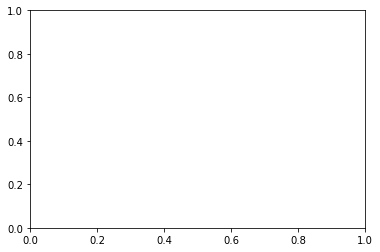

In [87]:
plt.plot(time, flux_system)
plt.xlabel("time [days]")
plt.ylabel("system flux");

In [39]:
planet.r = 0.33
system.show(t=np.linspace(0, 1, 50), window_pad=4, figsize=(8, 8))

Compiling `compute_rect_grid`... Done.
Compiling `compute_moll_grid`... Done.
Compiling `compute_ortho_grid`... Done.


# Generate Simulated Lightcurve with Exoplanet 

class exoplanet.orbits.KeplerianOrbit(period, a, t0, t_periastron,
incl, b, duration, ecc, omega, sin_omega, cos_omega, Omega, m_planet,
m_star, r_star, rho_star, ror, model)

In [72]:
def generate_lightcurve(period=3.456, u=[0.3,0.2],r=0.1,texp=0.02, b=0, m_star=1,r_star=1):
    """
    Function to generate lightcurve using Exoplanet

    Parameters
    ----------
    period : int, float
        Orbital period of planet
    u : list, array
        Quadratic Limb-darkening coefficients
    r : int, float
        Radius of planet in Solar radii
    texp : int, float
        Exposure time of lightcurve
    b : int, float
        Impact parameter
    m_star : int, float
        Mass of star in Solar masses
    r_star : int, float
        Radius of star in Solar radii
        

    Returns
    -------
    t : 1-D array
        Time array for the lightcurve
    lightcurve : 1-D array
        1-D flux array 
    """

    # The light curve calculation requires an orbit
    orbit = xo.orbits.KeplerianOrbit(period=period,b=b,m_star=m_star, r_star=r_star)

    # Compute a limb-darkened light curve using starry
    t = np.linspace(-0.1, 0.1, 1000)
    light_curve = (
        xo.LimbDarkLightCurve(*u)
        .get_light_curve(orbit=orbit, r=r, t=t, texp=texp)
        .eval()
    )
    # Note: the `eval` is needed because this is using Theano in
    # the background

    plt.plot(t, light_curve, color="C0", lw=2)
    plt.ylabel("relative flux")
    plt.xlabel("time [days]")
    _ = plt.xlim(t.min(), t.max())
    plt.show()
    plt.close()
    
    return t, light_curve

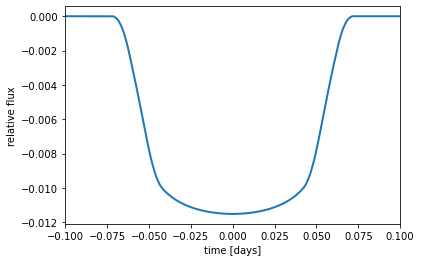

In [68]:
t,lc = generate_lightcurve()

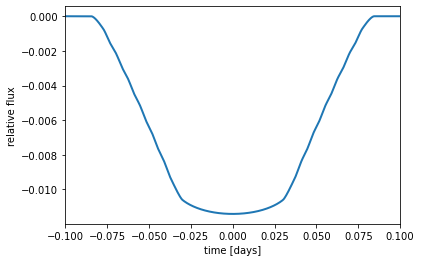

In [69]:
t,lc = generate_lightcurve(period=3.456, u=[0.3,0.2],r=0.1,texp=0.05)

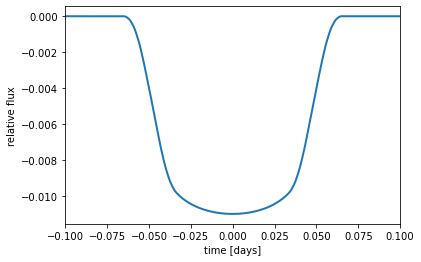

In [70]:
t,lc = generate_lightcurve(b=0.5)